In [1]:
import gc
import re
import math
import pickle
import joblib
import warnings

import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.model_selection import StratifiedKFold
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.linear_model import LogisticRegression

import lightgbm as lgb

warnings.simplefilter('ignore')

In [2]:
import os
import random as rn
import numpy as np


def set_seed(seed=0):
    os.environ["PYTHONHASHSEED"] = str(seed)

    rn.seed(seed)
    np.random.seed(seed)

In [3]:
from sklearn.metrics import log_loss


def score(Y, Y_pred):
    _, n_classes = Y.shape

    losses = []

    for j in range(n_classes):
        loss = log_loss(Y.iloc[:, j], Y_pred.iloc[:, j], labels=[0, 1])

        losses.append(loss)

    return np.mean(losses)

In [4]:
import sys
sys.path.append('../input/iterativestratification')

import numpy as np
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.model_selection._split import _BaseKFold


class MultilabelGroupStratifiedKFold(_BaseKFold):
    def __init__(self, n_splits=5, random_state=None, shuffle=False):
        super().__init__(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    def _iter_test_indices(self, X=None, y=None, groups=None):
        cv = MultilabelStratifiedKFold(
            n_splits=self.n_splits,
            random_state=self.random_state,
            shuffle=self.shuffle,
        )

        value_counts = groups.value_counts()
        regular_index = value_counts.loc[
            (value_counts == 6) | (value_counts == 12) | (value_counts == 18)
        ].index.sort_values()
        irregular_index = value_counts.loc[
            (value_counts != 6) & (value_counts != 12) & (value_counts != 18)
        ].index.sort_values()

        group_to_fold = {}
        tmp = Y.groupby(groups).mean().loc[regular_index]

        for fold, (_, test) in enumerate(cv.split(tmp, tmp)):
            group_to_fold.update({group: fold for group in tmp.index[test]})

        sample_to_fold = {}
        tmp = Y.loc[groups.isin(irregular_index)]

        for fold, (_, test) in enumerate(cv.split(tmp, tmp)):
            sample_to_fold.update({sample: fold for sample in tmp.index[test]})

        folds = groups.map(group_to_fold)
        is_na = folds.isna()
        folds[is_na] = folds[is_na].index.map(sample_to_fold).values

        for i in range(self.n_splits):
            yield np.where(folds == i)[0]

In [5]:
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin


class ClippedFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, copy=True, high=0.99, low=0.01):
        self.copy = copy
        self.high = high
        self.low = low

    def fit(self, X, y=None):
        self.data_max_ = X.quantile(q=self.high)
        self.data_min_ = X.quantile(q=self.low)

        return self

    def transform(self, X):
        if self.copy:
            X = X.copy()

        X.clip(self.data_min_, self.data_max_, axis=1, inplace=True)

        return X

In [6]:
import pandas as pd


def compute_row_statistics(X, prefix=""):
    Xt = pd.DataFrame()

    for agg_func in [
        # "min",
        # "max",
        "mean",
        "std",
        "kurtosis",
        "skew",
    ]:
        Xt[f"{prefix}{agg_func}"] = X.agg(agg_func, axis=1)

    return Xt

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt


def display_importances(
    importance_df, png_path=f"feature_importance.png",
):
    """feature_importance plot"""
    importance_df.sort_values(by="importance", ascending=False).to_csv(f"feature_importance.csv")
    cols = (
        importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:100]
        .index
    )
    best_features = importance_df.loc[importance_df.feature.isin(cols)]
    plt.figure(figsize=(8, 15))
    sns.barplot(
        x="importance",
        y="feature",
        data=best_features.sort_values(by="importance", ascending=False),
    )
    plt.title("LightGBM (avg over folds)")
    plt.tight_layout()
    plt.savefig(png_path)

In [8]:
#dtype = {"cp_type": "category", "cp_dose": "category"}
#index_col = "sig_id"
#
#train_features = pd.read_csv(
#   "../input/lish-moa/train_features.csv", dtype=dtype, index_col=index_col
#)
#X = train_features.select_dtypes("number")
#Y_nonscored = pd.read_csv(
#   "../input/lish-moa/train_targets_nonscored.csv", index_col=index_col
#)
#Y = pd.read_csv("../input/lish-moa/train_targets_scored.csv", index_col=index_col)
#groups = pd.read_csv(
#   "../input/lish-moa/train_drug.csv", index_col=index_col, squeeze=True
#)
#
#columns = Y.columns

In [9]:
dtype = {"cp_type": "category", "cp_dose": "category"}
index_col = "sig_id"

sys.path.append(
    r"C:\Users\81908\jupyter_notebook\poetry_work\tfgpu\01_MoA_compe\code"
)
import datasets

DATADIR = datasets.DATADIR

groups = pd.read_csv(f"{DATADIR}/train_drug.csv", dtype=dtype, index_col=index_col, squeeze=True)
train_features = pd.read_csv(f"{DATADIR}/train_features.csv", dtype=dtype, index_col=index_col)
#X_test = pd.read_csv(f"{DATADIR}/test_features.csv", dtype=dtype, index_col=index_col)
X = train_features.select_dtypes("number")
Y_nonscored = pd.read_csv(f"{DATADIR}/train_targets_nonscored.csv", index_col=index_col)
Y = pd.read_csv(f"{DATADIR}/train_targets_scored.csv", index_col=index_col)

columns = Y.columns

In [10]:
clipped_features = ClippedFeatures()
X = clipped_features.fit_transform(X)

with open("clipped_features.pkl", "wb") as f:
    pickle.dump(clipped_features, f)
# アンサンブルのために統計値, nonscoredは入れない 
#c_prefix = "c-"
#g_prefix = "g-"
#c_columns = X.columns.str.startswith(c_prefix)
#g_columns = X.columns.str.startswith(g_prefix)
#X_c = compute_row_statistics(X.loc[:, c_columns], prefix=c_prefix)
#X_g = compute_row_statistics(X.loc[:, g_columns], prefix=g_prefix)
#X = pd.concat([X, X_c, X_g], axis=1)

In [11]:
is_drug_cv = True
n_splits = 5
n_seeds = 1
# LBS = 0.0008  # ラベルスムージングは全然効かないからやめる
LBS = 0.0

params = {
    "num_leaves": 2,
    "max_depth": 1,
    "min_data_in_leaf": 969,
    "objective": "binary",
    "learning_rate": 0.01,
}
num_boost_round = 10000
verbose_eval = 300
early_stopping_rounds = verbose_eval

#DEBUG = True
DEBUG = False
if DEBUG:
    columns = [
        "atp-sensitive_potassium_channel_antagonist",  # 陽性ラベル1個だけ
        "erbb2_inhibitor",  # 陽性ラベル1個だけ
        "antiarrhythmic",  # 陽性ラベル6個だけ
#        "aldehyde_dehydrogenase_inhibitor",  # 陽性ラベル7個だけ
#        "lipase_inhibitor",  # 陽性ラベル12個だけ
#        "sphingosine_receptor_agonist",  # 陽性ラベル25個だけ
#        "igf-1_inhibitor",  # 陽性ラベル37個だけ
#        "potassium_channel_activator",  # 陽性ラベル55個だけ
#        "potassium_channel_antagonist",  # 陽性ラベル98個だけ
#        "dopamine_receptor_agonist",  # 陽性ラベル121個だけ
#        "nfkb_inhibitor",  # 陽性ラベル832個
#        "cyclooxygenase_inhibitor",  # 陽性ラベル435個
#        "dna_inhibitor",  # 陽性ラベル402個
#        "glutamate_receptor_antagonist",  # 陽性ラベル367個
#        "tubulin_inhibitor",  # 陽性ラベル316個
#        "pdgfr_inhibitor",  # 陽性ラベル297個
#        "calcium_channel_blocker",  # 陽性ラベル281個
#        "flt3_inhibitor",  # 陽性ラベル279個
#        "progesterone_receptor_agonist",  # 陽性ラベル119個
#        "hdac_inhibitor",  # 陽性ラベル106個
    ]
    Y = Y[columns]
    
    params["n_estimators"] = 2
    n_splits = 4
    num_boost_round = 50
    verbose_eval = 5
    early_stopping_rounds = verbose_eval
    print(f"DEBUG: {DEBUG}")

In [12]:
train_size, n_features = X.shape
_, n_classes_nonscored = Y_nonscored.shape
_, n_classes = Y.shape

In [13]:
%%time

counts = np.empty((n_seeds * len(columns) * n_splits))

f_importance = np.zeros((n_features,))
Y_pred = np.zeros((train_size, n_classes))
Y_pred = pd.DataFrame(Y_pred, columns=Y.columns, index=Y.index)

for i in range(n_seeds):
    set_seed(seed=i)

    for tar_i, tar_col in tqdm(enumerate(Y.columns)):
        Y_target = Y[[tar_col]]

        if is_drug_cv:
            cv = MultilabelGroupStratifiedKFold(
                n_splits=n_splits, random_state=i, shuffle=True
            )
            cv_split = cv.split(X, Y_target, groups)
        else:
            StratifiedKFold(n_splits=n_splits, random_state=i, shuffle=True)
            cv_split = cv.split(X, Y_target)

        for j, (trn_idx, val_idx) in enumerate(cv_split):
            print(f"\n------------ fold:{j} ------------")
            counts[i * len(columns) + tar_i * n_splits + j] = Y_target.iloc[trn_idx].sum()
            
            X_train, X_val = X.iloc[trn_idx], X.iloc[val_idx]
            Y_train, Y_val = Y_target.iloc[trn_idx], Y_target.iloc[val_idx]

            # Label Smoothing. https://www.kaggle.com/gogo827jz/self-stacking-groupcv-xgboost
            Y_train = Y_train * (1 - LBS) + 0.5 * LBS
            
            lgb_train = lgb.Dataset(X_train, Y_train)
            lgb_eval = lgb.Dataset(X_val, Y_val, reference=lgb_train)
            
            model = lgb.train(
                params,
                lgb_train,
                valid_sets=[lgb_train, lgb_eval],
                verbose_eval=verbose_eval,
                num_boost_round=num_boost_round,
                early_stopping_rounds=early_stopping_rounds,
            )
            Y_pred[tar_col][val_idx] += model.predict(X_val, num_iteration=model.best_iteration) / n_seeds
            
            f_importance += np.array(model.feature_importance(importance_type="gain")) / (n_seeds * n_splits)
            
            joblib.dump(model, f"model_seed_{i}_fold_{j}_{Y.columns[tar_i]}.jlb", compress=True)

importance_df = pd.DataFrame({"feature": model.feature_name(), "importance": f_importance})
            
Y_pred[train_features["cp_type"] == "ctl_vehicle"] = 0.0

with open("counts.pkl", "wb") as f:
    pickle.dump(counts, f)

with open("Y_pred.pkl", "wb") as f:
    pickle.dump(Y_pred[columns], f)

0it [00:00, ?it/s]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 10, number of negative: 19012
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.211360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000526 -> initscore=-7.550241
[LightGBM] [Info] Start training from score -7.550241
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00252526	valid_1's binary_logloss: 0.0107158
[600]	training's binary_logloss: 0.00151945	valid_1's binary_logloss: 0.0104838
Early stopping, best iteration is:
[528]	training's binary_logloss: 0.00172104	valid_1's binary_logloss: 0.0104423

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 16, number of negative: 19030
[LightGBM] [Warning] Auto-choo

1it [01:27, 87.80s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 12, number of negative: 19010
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000631 -> initscore=-7.367814
[LightGBM] [Info] Start training from score -7.367814
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00360359	valid_1's binary_logloss: 0.0099659
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00526647	valid_1's binary_logloss: 0.00986278

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 18, number of negative: 19028
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.148159 seconds.
You 

2it [03:42, 101.94s/it]

Early stopping, best iteration is:
[157]	training's binary_logloss: 0.00437454	valid_1's binary_logloss: 0.00971059

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 18, number of negative: 19004
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.146516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000946 -> initscore=-6.962033
[LightGBM] [Info] Start training from score -6.962033
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00570952	valid_1's binary_logloss: 0.0100461
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00752051	valid_1's binary_logloss: 0.00966749

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 18, number of negative: 1

3it [04:12, 80.36s/it] 

[300]	training's binary_logloss: 0.00789989	valid_1's binary_logloss: 0.00126719
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00966191	valid_1's binary_logloss: 0.00126134

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 149, number of negative: 18873
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.157832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007833 -> initscore=-4.841541
[LightGBM] [Info] Start training from score -4.841541
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0431804	valid_1's binary_logloss: 0.0490408
[600]	training's binary_logloss: 0.0416502	valid_1's binary_logloss: 0.0489842
[900]	training's binary_logloss: 0.0403412	valid_1's 

4it [05:04, 71.77s/it]

Early stopping, best iteration is:
[509]	training's binary_logloss: 0.0435167	valid_1's binary_logloss: 0.0435847

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 238, number of negative: 18784
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.231046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.012512 -> initscore=-4.368490
[LightGBM] [Info] Start training from score -4.368490
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0638088	valid_1's binary_logloss: 0.067698
[600]	training's binary_logloss: 0.0620838	valid_1's binary_logloss: 0.0674076
[900]	training's binary_logloss: 0.0607153	valid_1's binary_logloss: 0.0674761
Early stopping, best iteration is:
[652]	training's bina

5it [06:01, 67.47s/it]

Early stopping, best iteration is:
[817]	training's binary_logloss: 0.0621434	valid_1's binary_logloss: 0.0627658

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 55, number of negative: 18967
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.203479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002891 -> initscore=-5.843123
[LightGBM] [Info] Start training from score -5.843123
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0177182	valid_1's binary_logloss: 0.0251524
Early stopping, best iteration is:
[8]	training's binary_logloss: 0.0196988	valid_1's binary_logloss: 0.0247978

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 61, number of negative: 18985


6it [06:51, 62.22s/it]

[300]	training's binary_logloss: 0.0196278	valid_1's binary_logloss: 0.0177952
Early stopping, best iteration is:
[8]	training's binary_logloss: 0.0215147	valid_1's binary_logloss: 0.0175958

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 42, number of negative: 18980
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.199415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002208 -> initscore=-6.113471
[LightGBM] [Info] Start training from score -6.113471
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0137137	valid_1's binary_logloss: 0.0175111
Early stopping, best iteration is:
[95]	training's binary_logloss: 0.0148975	valid_1's binary_logloss: 0.0173819

------------ fold:1 ---

7it [07:24, 53.29s/it]

[300]	training's binary_logloss: 0.0117335	valid_1's binary_logloss: 0.025883
Early stopping, best iteration is:
[13]	training's binary_logloss: 0.0135982	valid_1's binary_logloss: 0.0254558

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 80, number of negative: 18942
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.195671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004206 -> initscore=-5.467110
[LightGBM] [Info] Start training from score -5.467110
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0252916	valid_1's binary_logloss: 0.0226294
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0271953	valid_1's binary_logloss: 0.0224712

------------ fold:1 ----

8it [07:57, 47.19s/it]

[300]	training's binary_logloss: 0.0233853	valid_1's binary_logloss: 0.0294785
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0254383	valid_1's binary_logloss: 0.0294557

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 6, number of negative: 19016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.159857 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000315 -> initscore=-8.061277
[LightGBM] [Info] Start training from score -8.061277
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.000647765	valid_1's binary_logloss: 0.00932216
Early stopping, best iteration is:
[149]	training's binary_logloss: 0.00120193	valid_1's binary_logloss: 0.00891908

------------ fold:

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t


------------ fold:3 ------------
[LightGBM] [Info] Number of positive: 12, number of negative: 19065
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.191389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19077, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000629 -> initscore=-7.370703
[LightGBM] [Info] Start training from score -7.370703
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00167269	valid_1's binary_logloss: 0.000485867
[600]	training's binary_logloss: 0.000727667	valid_1's binary_logloss: 0.000280329
[900]	training's binary_logloss: 0.000330807	valid_1's binary_logloss: 0.000150477
[1200]	training's binary_logloss: 0.000154734	valid_1's binary_logloss: 7.86827e-05
[1500]	training's binary_logloss: 7.46109e-05	valid_1's binary_logloss: 4.2

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

9it [11:07, 90.23s/it]

Early stopping, best iteration is:
[218]	training's binary_logloss: 0.000616665	valid_1's binary_logloss: 0.00892611

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 213, number of negative: 18809
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.155047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.011198 -> initscore=-4.480799
[LightGBM] [Info] Start training from score -4.480799
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0579733	valid_1's binary_logloss: 0.0624324
[600]	training's binary_logloss: 0.055774	valid_1's binary_logloss: 0.0613053
[900]	training's binary_logloss: 0.0539723	valid_1's binary_logloss: 0.0605143
[1200]	training's binary_logloss: 0.0523928	valid_1's

[2400]	training's binary_logloss: 0.0489656	valid_1's binary_logloss: 0.0536033
[2700]	training's binary_logloss: 0.0478815	valid_1's binary_logloss: 0.0533322
[3000]	training's binary_logloss: 0.0468488	valid_1's binary_logloss: 0.0531108
[3300]	training's binary_logloss: 0.0458621	valid_1's binary_logloss: 0.0528938
[3600]	training's binary_logloss: 0.0449218	valid_1's binary_logloss: 0.0527395
[3900]	training's binary_logloss: 0.0440059	valid_1's binary_logloss: 0.0525898
[4200]	training's binary_logloss: 0.0431362	valid_1's binary_logloss: 0.0524615
[4500]	training's binary_logloss: 0.0422987	valid_1's binary_logloss: 0.0523785
[4800]	training's binary_logloss: 0.0414881	valid_1's binary_logloss: 0.0523458
[5100]	training's binary_logloss: 0.0407064	valid_1's binary_logloss: 0.0522993
[5400]	training's binary_logloss: 0.0399487	valid_1's binary_logloss: 0.0522815
[5700]	training's binary_logloss: 0.039216	valid_1's binary_logloss: 0.0523001
Early stopping, best iteration is:
[5513]

10it [15:27, 140.90s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 288, number of negative: 18734
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.174682 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.015140 -> initscore=-4.175135
[LightGBM] [Info] Start training from score -4.175135
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0751194	valid_1's binary_logloss: 0.0762036
[600]	training's binary_logloss: 0.0734072	valid_1's binary_logloss: 0.0758475
[900]	training's binary_logloss: 0.0720195	valid_1's binary_logloss: 0.0755894
[1200]	training's binary_logloss: 0.0707864	valid_1's binary_logloss: 0.0754377
[1500]	training's binary_logloss: 0.069655	valid_1's binary_logloss: 0.0753781
[1800]	tra

11it [16:58, 126.06s/it]

Early stopping, best iteration is:
[1148]	training's binary_logloss: 0.0720744	valid_1's binary_logloss: 0.0707805

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 57, number of negative: 18965
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.181532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002997 -> initscore=-5.807299
[LightGBM] [Info] Start training from score -5.807299
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0149075	valid_1's binary_logloss: 0.0129457
Early stopping, best iteration is:
[131]	training's binary_logloss: 0.016876	valid_1's binary_logloss: 0.0128876

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 52, number of negative: 1899

12it [19:28, 133.39s/it]

Early stopping, best iteration is:
[95]	training's binary_logloss: 0.0154182	valid_1's binary_logloss: 0.019282

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 5, number of negative: 19017
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.139257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000263 -> initscore=-8.243651
[LightGBM] [Info] Start training from score -8.243651
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.000386692	valid_1's binary_logloss: 0.00236901
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.000388543	valid_1's binary_logloss: 0.00236537

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 6, number of negative: 19


------------ fold:2 ------------
[LightGBM] [Info] Number of positive: 6, number of negative: 19065
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.156724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19071, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000315 -> initscore=-8.063850
[LightGBM] [Info] Start training from score -8.063850
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.000421633	valid_1's binary_logloss: 0.00158609
[600]	training's binary_logloss: 0.000110989	valid_1's binary_logloss: 0.00155789
Early stopping, best iteration is:
[518]	training's binary_logloss: 0.000157167	valid_1's binary_logloss: 0.00154828

------------ fold:3 ------------
[LightGBM] [Info] Number of positive: 5, number of negative: 19072
[LightGBM] [Warning] Auto-

13it [21:11, 124.20s/it]

Early stopping, best iteration is:
[486]	training's binary_logloss: 0.00021824	valid_1's binary_logloss: 0.00127578

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 36, number of negative: 18986
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.336828 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001893 -> initscore=-6.267938
[LightGBM] [Info] Start training from score -6.267938
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0101077	valid_1's binary_logloss: 0.00944825
[600]	training's binary_logloss: 0.00847975	valid_1's binary_logloss: 0.00944118
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00930433	valid_1's binary_logloss: 0.009381

------------ fo

14it [23:39, 131.27s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 6, number of negative: 19016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.161481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000315 -> initscore=-8.061277
[LightGBM] [Info] Start training from score -8.061277
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.000922953	valid_1's binary_logloss: 0.0114112
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.00283152	valid_1's binary_logloss: 0.0104081

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 12, number of negative: 19034
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.174006 seconds.
You c

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

15it [31:56, 240.84s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 12, number of negative: 19010
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.149761 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000631 -> initscore=-7.367814
[LightGBM] [Info] Start training from score -7.367814
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0033201	valid_1's binary_logloss: 0.000616871
[600]	training's binary_logloss: 0.00225824	valid_1's binary_logloss: 0.000561925
[900]	training's binary_logloss: 0.00150256	valid_1's binary_logloss: 0.000468987
[1200]	training's binary_logloss: 0.000963105	valid_1's binary_logloss: 0.000364795
[1500]	training's binary_logloss: 0.000612464	valid_1's binary_logloss: 0.0002

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Info] Number of positive: 6, number of negative: 19040
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.158127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19046, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000315 -> initscore=-8.062538
[LightGBM] [Info] Start training from score -8.062538
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00117823	valid_1's binary_logloss: 0.0112562
Early stopping, best iteration is:
[7]	training's binary_logloss: 0.00276893	valid_1's binary_logloss: 0.0103858

------------ fold:2 ------------
[LightGBM] [Info] Number of positive: 12, number of negative: 19059
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.168554 seconds.
You can set `force_col_wise=true` to rem

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

16it [36:22, 248.46s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 36, number of negative: 18986
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.308146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001893 -> initscore=-6.267938
[LightGBM] [Info] Start training from score -6.267938
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0117941	valid_1's binary_logloss: 0.0173974
Early stopping, best iteration is:
[219]	training's binary_logloss: 0.0122202	valid_1's binary_logloss: 0.0173896

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 42, number of negative: 19004
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.181143 seconds.
You c

17it [37:11, 188.75s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 76, number of negative: 18946
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.164141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003995 -> initscore=-5.518615
[LightGBM] [Info] Start training from score -5.518615
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0239332	valid_1's binary_logloss: 0.0192508
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0260386	valid_1's binary_logloss: 0.018981

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 70, number of negative: 18976
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.150195 seconds.
You can 

18it [37:54, 145.04s/it]

Early stopping, best iteration is:
[126]	training's binary_logloss: 0.0233554	valid_1's binary_logloss: 0.0257599

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 59, number of negative: 18963
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.137701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003102 -> initscore=-5.772708
[LightGBM] [Info] Start training from score -5.772708
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0189265	valid_1's binary_logloss: 0.0284987
Early stopping, best iteration is:
[128]	training's binary_logloss: 0.0199941	valid_1's binary_logloss: 0.028372

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 65, number of negative: 18981

19it [39:05, 122.66s/it]

Early stopping, best iteration is:
[447]	training's binary_logloss: 0.0199702	valid_1's binary_logloss: 0.0209144

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 24, number of negative: 18998
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.193680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001262 -> initscore=-6.674035
[LightGBM] [Info] Start training from score -6.674035
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00764459	valid_1's binary_logloss: 0.019286
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00967035	valid_1's binary_logloss: 0.0179771

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 30, number of negative: 19016

20it [39:49, 99.24s/it] 

[300]	training's binary_logloss: 0.0100494	valid_1's binary_logloss: 0.00975163
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0117319	valid_1's binary_logloss: 0.00969066

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 29, number of negative: 18993
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.154347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001525 -> initscore=-6.484530
[LightGBM] [Info] Start training from score -6.484530
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00959718	valid_1's binary_logloss: 0.0120682
[600]	training's binary_logloss: 0.00832741	valid_1's binary_logloss: 0.0120427
[900]	training's binary_logloss: 0.00723221	valid_1's 

21it [40:32, 82.31s/it]

Early stopping, best iteration is:
[29]	training's binary_logloss: 0.011499	valid_1's binary_logloss: 0.010984

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 59, number of negative: 18963
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.149492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003102 -> initscore=-5.772708
[LightGBM] [Info] Start training from score -5.772708
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0184196	valid_1's binary_logloss: 0.0181418
[600]	training's binary_logloss: 0.016773	valid_1's binary_logloss: 0.0176141
[900]	training's binary_logloss: 0.0154793	valid_1's binary_logloss: 0.0175897
Early stopping, best iteration is:
[685]	training's binary_l

22it [42:04, 85.16s/it]

Early stopping, best iteration is:
[27]	training's binary_logloss: 0.020356	valid_1's binary_logloss: 0.0199484

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 6, number of negative: 19016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.241604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000315 -> initscore=-8.061277
[LightGBM] [Info] Start training from score -8.061277
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00142753	valid_1's binary_logloss: 0.000294302
[600]	training's binary_logloss: 0.000659885	valid_1's binary_logloss: 0.000222097
[900]	training's binary_logloss: 0.000277364	valid_1's binary_logloss: 0.000118671
[1200]	training's binary_logloss: 0.000115169	va

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 


------------ fold:2 ------------
[LightGBM] [Info] Number of positive: 6, number of negative: 19065
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177956 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19071, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000315 -> initscore=-8.063850
[LightGBM] [Info] Start training from score -8.063850
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00142026	valid_1's binary_logloss: 0.000306311
[600]	training's binary_logloss: 0.000654777	valid_1's binary_logloss: 0.000234484
[900]	training's binary_logloss: 0.000274458	valid_1's binary_logloss: 0.000126527
[1200]	training's binary_logloss: 0.000113766	valid_1's binary_logloss: 5.82281e-05
[1500]	training's binary_logloss: 4.7941e-05	valid_1's binary_logloss: 2.578

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[300]	training's binary_logloss: 0.00141498	valid_1's binary_logloss: 0.00030151
[600]	training's binary_logloss: 0.00065136	valid_1's binary_logloss: 0.000231313
[900]	training's binary_logloss: 0.000272835	valid_1's binary_logloss: 0.000123934
[1200]	training's binary_logloss: 0.000113063	valid_1's binary_logloss: 5.67159e-05
[1500]	training's binary_logloss: 4.75901e-05	valid_1's binary_logloss: 2.51524e-05
[1800]	training's binary_logloss: 2.04995e-05	valid_1's binary_logloss: 1.12428e-05
[2100]	training's binary_logloss: 9.02385e-06	valid_1's binary_logloss: 5.1571e-06
[2400]	training's binary_logloss: 4.05089e-06	valid_1's binary_logloss: 2.41557e-06
[2700]	training's binary_logloss: 1.84934e-06	valid_1's binary_logloss: 1.16026e-06
[3000]	training's binary_logloss: 8.56347e-07	valid_1's binary_logloss: 5.72107e-07
[3300]	training's binary_logloss: 4.01472e-07	valid_1's binary_logloss: 2.87516e-07
[3600]	training's binary_logloss: 1.93817e-07	valid_1's binary_logloss: 1.4309e-07


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

23it [45:50, 127.36s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 37, number of negative: 18985
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.357400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001945 -> initscore=-6.240487
[LightGBM] [Info] Start training from score -6.240487
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0109653	valid_1's binary_logloss: 0.0101315
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0140518	valid_1's binary_logloss: 0.00976448

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 37, number of negative: 19009
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176586 seconds.
You ca

24it [46:23, 99.27s/it] 

Early stopping, best iteration is:
[51]	training's binary_logloss: 0.0111682	valid_1's binary_logloss: 0.0177341

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 12, number of negative: 19010
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.219981 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000631 -> initscore=-7.367814
[LightGBM] [Info] Start training from score -7.367814
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00364518	valid_1's binary_logloss: 0.00062446
[600]	training's binary_logloss: 0.00256294	valid_1's binary_logloss: 0.000594458
[900]	training's binary_logloss: 0.0017619	valid_1's binary_logloss: 0.000536273
[1200]	training's binary_logloss: 0.00117573	valid

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

25it [50:46, 148.23s/it]

[300]	training's binary_logloss: 0.00133077	valid_1's binary_logloss: 0.0110493
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00284341	valid_1's binary_logloss: 0.0104539

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 12, number of negative: 19010
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.152908 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000631 -> initscore=-7.367814
[LightGBM] [Info] Start training from score -7.367814
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.003243	valid_1's binary_logloss: 0.00217128
[600]	training's binary_logloss: 0.00199663	valid_1's binary_logloss: 0.0020265
[900]	training's binary_logloss: 0.00120006	valid_1's b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Early stopping, best iteration is:
[8364]	training's binary_logloss: 1.04776e-07	valid_1's binary_logloss: 2.40719e-06

------------ fold:4 ------------
[LightGBM] [Info] Number of positive: 7, number of negative: 19033
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.159689 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19040, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000368 -> initscore=-7.908019
[LightGBM] [Info] Start training from score -7.

26it [53:13, 147.83s/it]

Early stopping, best iteration is:
[37]	training's binary_logloss: 0.00283596	valid_1's binary_logloss: 0.010315

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 6, number of negative: 19016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.156960 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000315 -> initscore=-8.061277
[LightGBM] [Info] Start training from score -8.061277
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00145361	valid_1's binary_logloss: 0.0109433
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.00266427	valid_1's binary_logloss: 0.0103323

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 12, number of negative: 19034

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19071, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000629 -> initscore=-7.370388
[LightGBM] [Info] Start training from score -7.370388
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00355885	valid_1's binary_logloss: 0.00063109
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00525074	valid_1's binary_logloss: 0.000629742

------------ fold:3 ------------
[LightGBM] [Info] Number of positive: 6, number of negative: 19071
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.272831 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19077, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000315 -> initscore=-8.064165
[L

27it [55:41, 147.93s/it]

[300]	training's binary_logloss: 0.00356102	valid_1's binary_logloss: 0.000634347
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00525837	valid_1's binary_logloss: 0.000630636

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 12, number of negative: 19010
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.210944 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000631 -> initscore=-7.367814
[LightGBM] [Info] Start training from score -7.367814
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00356383	valid_1's binary_logloss: 0.0104917
Early stopping, best iteration is:
[10]	training's binary_logloss: 0.0051688	valid_1's binary_logloss: 0.009751

------------ fold

28it [56:10, 112.34s/it]

[300]	training's binary_logloss: 0.00311678	valid_1's binary_logloss: 0.0104603
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00524127	valid_1's binary_logloss: 0.0099013

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 60, number of negative: 18962
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.151232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003154 -> initscore=-5.755848
[LightGBM] [Info] Start training from score -5.755848
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0190122	valid_1's binary_logloss: 0.0187502
Early stopping, best iteration is:
[48]	training's binary_logloss: 0.0207797	valid_1's binary_logloss: 0.0185808

------------ fold:1 -

29it [57:30, 102.68s/it]

Early stopping, best iteration is:
[249]	training's binary_logloss: 0.0194467	valid_1's binary_logloss: 0.0181895

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 30, number of negative: 18992
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.179787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001577 -> initscore=-6.450576
[LightGBM] [Info] Start training from score -6.450576
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0099325	valid_1's binary_logloss: 0.00961828
[600]	training's binary_logloss: 0.00864256	valid_1's binary_logloss: 0.00966328
Early stopping, best iteration is:
[376]	training's binary_logloss: 0.00957834	valid_1's binary_logloss: 0.00959394

------------ fo

30it [58:04, 82.02s/it] 

[300]	training's binary_logloss: 0.00973364	valid_1's binary_logloss: 0.00995629
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0117298	valid_1's binary_logloss: 0.00969072

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 22, number of negative: 19000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.138716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001157 -> initscore=-6.761152
[LightGBM] [Info] Start training from score -6.761152
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00694524	valid_1's binary_logloss: 0.00251305
Early stopping, best iteration is:
[201]	training's binary_logloss: 0.00748857	valid_1's binary_logloss: 0.00249319

------------ fo

31it [58:41, 68.38s/it]

Early stopping, best iteration is:
[77]	training's binary_logloss: 0.00608781	valid_1's binary_logloss: 0.0110856

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 37, number of negative: 18985
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.154594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001945 -> initscore=-6.240487
[LightGBM] [Info] Start training from score -6.240487
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0123384	valid_1's binary_logloss: 0.0179558
Early stopping, best iteration is:
[16]	training's binary_logloss: 0.0139436	valid_1's binary_logloss: 0.0174683

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 43, number of negative: 19003

32it [59:09, 56.27s/it]

[300]	training's binary_logloss: 0.0136918	valid_1's binary_logloss: 0.00994084
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0159938	valid_1's binary_logloss: 0.00991934

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 40, number of negative: 18982
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.154519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002103 -> initscore=-6.162367
[LightGBM] [Info] Start training from score -6.162367
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0130324	valid_1's binary_logloss: 0.0110187
[600]	training's binary_logloss: 0.0116541	valid_1's binary_logloss: 0.0110163
Early stopping, best iteration is:
[458]	training's bina

33it [1:00:00, 54.84s/it]

Early stopping, best iteration is:
[209]	training's binary_logloss: 0.0117167	valid_1's binary_logloss: 0.0189358

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 6, number of negative: 19016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.145919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000315 -> initscore=-8.061277
[LightGBM] [Info] Start training from score -8.061277
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.000758506	valid_1's binary_logloss: 0.000258639
[600]	training's binary_logloss: 0.000235229	valid_1's binary_logloss: 0.000113564
[900]	training's binary_logloss: 7.94678e-05	valid_1's binary_logloss: 4.31034e-05
[1200]	training's binary_logloss: 2.84237e-05

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[3300]	training's binary_logloss: 1.04983e-07	valid_1's binary_logloss: 6.36172e-08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 


------------ fold:3 ------------
[LightGBM] [Info] Number of positive: 6, number of negative: 19071
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.154723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19077, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000315 -> initscore=-8.064165
[LightGBM] [Info] Start training from score -8.064165
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.000755971	valid_1's binary_logloss: 0.000254831
[600]	training's binary_logloss: 0.000235123	valid_1's binary_logloss: 0.000104641
[900]	training's binary_logloss: 7.94294e-05	valid_1's binary_logloss: 3.91311e-05
[1200]	training's binary_logloss: 2.83323e-05	valid_1's binary_logloss: 1.55141e-05
[1500]	training's binary_logloss: 1.05367e-05	valid_1's binary_logloss: 6.5

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[3300]	training's binary_logloss: 1.05042e-07	valid_1's binary_logloss: 1.33285e-07
[LightGBM] [Warning] 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

34it [1:02:47, 88.34s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 1, number of negative: 19021
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.173844 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000053 -> initscore=-9.853299
[LightGBM] [Info] Start training from score -9.853299
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 9.47596e-06	valid_1's binary_logloss: 4.38429e-06
[600]	training's binary_logloss: 6.29402e-07	valid_1's binary_logloss: 2.86674e-07
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

35it [1:03:47, 79.97s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 6, number of negative: 19016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.235258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000315 -> initscore=-8.061277
[LightGBM] [Info] Start training from score -8.061277
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.000359422	valid_1's binary_logloss: 0.00598484
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.000373365	valid_1's binary_logloss: 0.00597612

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 12, number of negative: 19034
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.127758 seconds.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Early stopping, best iteration is:
[3926]	training's binary_logloss: 1.05008e-07	valid_1's binary_logloss: 9.17772e-07

------------ fold:2 ------------
[LightGBM] [Info] Number of positive: 12, number of negative: 19059
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, th

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t


------------ fold:3 ------------
[LightGBM] [Info] Number of positive: 6, number of negative: 19071
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.144948 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19077, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000315 -> initscore=-8.064165
[LightGBM] [Info] Start training from score -8.064165
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.000376682	valid_1's binary_logloss: 0.00678135
Early stopping, best iteration is:
[197]	training's binary_logloss: 0.000621496	valid_1's binary_logloss: 0.00661157

------------ fold:4 ------------
[LightGBM] [Info] Number of positive: 12, number of negative: 19028
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.194106 seconds.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

36it [1:06:34, 106.11s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 79, number of negative: 18943
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.191814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004153 -> initscore=-5.479742
[LightGBM] [Info] Start training from score -5.479742
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0216024	valid_1's binary_logloss: 0.0208259
[600]	training's binary_logloss: 0.0198421	valid_1's binary_logloss: 0.0206694
[900]	training's binary_logloss: 0.0185101	valid_1's binary_logloss: 0.0204214
[1200]	training's binary_logloss: 0.0173796	valid_1's binary_logloss: 0.0203306
[1500]	training's binary_logloss: 0.0163622	valid_1's binary_logloss: 0.0203096
[1800]	tra

37it [1:08:26, 107.70s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 12, number of negative: 19010
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.213890 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000631 -> initscore=-7.367814
[LightGBM] [Info] Start training from score -7.367814
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00247262	valid_1's binary_logloss: 0.00871247
[600]	training's binary_logloss: 0.00132747	valid_1's binary_logloss: 0.00824469
[900]	training's binary_logloss: 0.000721137	valid_1's binary_logloss: 0.00834916
Early stopping, best iteration is:
[648]	training's binary_logloss: 0.00120162	valid_1's binary_logloss: 0.00820902

------------ fold:1 ------------
[LightGBM] [I

38it [1:10:32, 113.32s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 76, number of negative: 18946
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.150306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003995 -> initscore=-5.518615
[LightGBM] [Info] Start training from score -5.518615
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0159005	valid_1's binary_logloss: 0.0209659
[600]	training's binary_logloss: 0.0126713	valid_1's binary_logloss: 0.020463
[900]	training's binary_logloss: 0.0104535	valid_1's binary_logloss: 0.0203741
Early stopping, best iteration is:
[869]	training's binary_logloss: 0.0106538	valid_1's binary_logloss: 0.0203239

------------ fold:1 ------------
[LightGBM] [Info] Numbe

39it [1:14:05, 143.26s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 6, number of negative: 19016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.383856 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000315 -> initscore=-8.061277
[LightGBM] [Info] Start training from score -8.061277
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.000858119	valid_1's binary_logloss: 0.000254371
[600]	training's binary_logloss: 0.000317066	valid_1's binary_logloss: 0.000135374
[900]	training's binary_logloss: 0.000125188	valid_1's binary_logloss: 6.00163e-05
[1200]	training's binary_logloss: 5.17116e-05	valid_1's binary_logloss: 2.6444e-05
[1500]	training's binary_logloss: 2.21454e-05	valid_1's binary_logloss: 1.18

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 


------------ fold:2 ------------
[LightGBM] [Info] Number of positive: 6, number of negative: 19065
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.166622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19071, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000315 -> initscore=-8.063850
[LightGBM] [Info] Start training from score -8.063850
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.000857915	valid_1's binary_logloss: 0.00025992
[600]	training's binary_logloss: 0.000318352	valid_1's binary_logloss: 0.000137052
[900]	training's binary_logloss: 0.000125317	valid_1's binary_logloss: 6.31481e-05
[1200]	training's binary_logloss: 5.16512e-05	valid_1's binary_logloss: 2.87476e-05
[1500]	training's binary_logloss: 2.21206e-05	valid_1's binary_logloss: 1.32

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t


------------ fold:3 ------------
[LightGBM] [Info] Number of positive: 6, number of negative: 19071
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.271771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19077, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000315 -> initscore=-8.064165
[LightGBM] [Info] Start training from score -8.064165
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.000845075	valid_1's binary_logloss: 0.000267483
[600]	training's binary_logloss: 0.0003101	valid_1's binary_logloss: 0.000138674
[900]	training's binary_logloss: 0.000122175	valid_1's binary_logloss: 6.12043e-05
[1200]	training's binary_logloss: 5.05598e-05	valid_1's binary_logloss: 2.64438e-05
[1500]	training's binary_logloss: 2.17185e-05	valid_1's binary_logloss: 1.169

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[2400]	training's binary_logloss: 2.06144e-06	valid_1's binary_logloss: 1.22598e-06
[2700]	training's binary_logloss: 9.73682e-07	valid_1's binary_logloss: 6.11294e-07
[3000]	training's binary_logloss: 4.66295e-07	valid_1's binary_logloss: 3.16703e-07
[3300]	training's binary_logloss: 2.2634e-07	valid_1's binary_logloss: 1.64505e-07
[3600]	training's binary_logloss: 1.16197e-07	valid_1's binary_logloss: 8.86921e-08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

40it [1:17:26, 160.50s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 48, number of negative: 18974
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.192772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002523 -> initscore=-5.979624
[LightGBM] [Info] Start training from score -5.979624
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0157438	valid_1's binary_logloss: 0.0175864
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0176029	valid_1's binary_logloss: 0.0175034

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 48, number of negative: 18998
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.148315 seconds.
You can

41it [1:18:13, 126.51s/it]

[300]	training's binary_logloss: 0.0154769	valid_1's binary_logloss: 0.0180055
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.0175112	valid_1's binary_logloss: 0.0175528

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 64, number of negative: 18958
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.365373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003365 -> initscore=-5.691098
[LightGBM] [Info] Start training from score -5.691098
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0201734	valid_1's binary_logloss: 0.0223581
[600]	training's binary_logloss: 0.018585	valid_1's binary_logloss: 0.0223881
Early stopping, best iteration is:
[378]	training's binary_

42it [1:20:09, 123.32s/it]

Early stopping, best iteration is:
[1732]	training's binary_logloss: 0.0139329	valid_1's binary_logloss: 0.0220109

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 24, number of negative: 18998
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.145348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001262 -> initscore=-6.674035
[LightGBM] [Info] Start training from score -6.674035
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00742829	valid_1's binary_logloss: 0.0173453
Early stopping, best iteration is:
[256]	training's binary_logloss: 0.00768246	valid_1's binary_logloss: 0.0173038

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 30, number of negative: 1

43it [1:21:27, 109.65s/it]

Early stopping, best iteration is:
[1062]	training's binary_logloss: 0.00651114	valid_1's binary_logloss: 0.00867155

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 158, number of negative: 18864
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.175154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008306 -> initscore=-4.782416
[LightGBM] [Info] Start training from score -4.782416
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0452094	valid_1's binary_logloss: 0.0416509
[600]	training's binary_logloss: 0.0434957	valid_1's binary_logloss: 0.0414269
[900]	training's binary_logloss: 0.0420612	valid_1's binary_logloss: 0.0414711
Early stopping, best iteration is:
[649]	training's 

44it [1:22:32, 96.33s/it] 

Early stopping, best iteration is:
[528]	training's binary_logloss: 0.0439561	valid_1's binary_logloss: 0.0408706

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 70, number of negative: 18952
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.171845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003680 -> initscore=-5.601170
[LightGBM] [Info] Start training from score -5.601170
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0219096	valid_1's binary_logloss: 0.0257169
Early stopping, best iteration is:
[278]	training's binary_logloss: 0.0220455	valid_1's binary_logloss: 0.0256965

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 76, number of negative: 1897

45it [1:23:50, 90.72s/it]

Early stopping, best iteration is:
[791]	training's binary_logloss: 0.0199679	valid_1's binary_logloss: 0.0252161

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 90, number of negative: 18932
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.144391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004731 -> initscore=-5.348799
[LightGBM] [Info] Start training from score -5.348799
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0277932	valid_1's binary_logloss: 0.0318912
[600]	training's binary_logloss: 0.026218	valid_1's binary_logloss: 0.0316042
[900]	training's binary_logloss: 0.0248547	valid_1's binary_logloss: 0.0315217
[1200]	training's binary_logloss: 0.0236079	valid_1's bin

46it [1:25:33, 94.43s/it]

[300]	training's binary_logloss: 0.0288346	valid_1's binary_logloss: 0.0273149
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0314057	valid_1's binary_logloss: 0.0271904

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 7, number of negative: 19015
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.154930 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000368 -> initscore=-7.907073
[LightGBM] [Info] Start training from score -7.907073
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.000455708	valid_1's binary_logloss: 0.000221028
[600]	training's binary_logloss: 0.000160537	valid_1's binary_logloss: 0.000114762
[900]	training's binary_logloss: 6.25538e-05	valid_

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

Early stopping, best iteration is:
[506]	training's binary_logloss: 0.000141774	valid_1's binary_logloss: 0.00134026

------------ fold:2 ------------
[LightGBM] [Info] Number of positive: 7, number of negative: 19064
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.148880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19071, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000367 -> initscore=-7.909647
[LightGBM] [Info] Start training from score -7.909647
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.000441175	valid_1's binary_logloss: 0.000232781
[600]	training's binary_logloss: 0.000154769	valid_1's binary_logloss: 0.000100886
[900]	training's binary_logloss: 6.06693e-05	valid_1's binary_logloss: 4.97254e-05
[1200]	training's binary_logloss: 2.50685e

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[3300]	training's binary_logloss: 1.04834e-07	valid_1's binary_logloss: 6.02376e-07
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

47it [1:28:04, 111.32s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 22, number of negative: 19000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.159233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001157 -> initscore=-6.761152
[LightGBM] [Info] Start training from score -6.761152
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00612045	valid_1's binary_logloss: 0.0122931
Early stopping, best iteration is:
[183]	training's binary_logloss: 0.00686229	valid_1's binary_logloss: 0.0122508

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 22, number of negative: 19024
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.179144 seconds.
You

48it [1:30:58, 130.37s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 29, number of negative: 18993
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.343272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001525 -> initscore=-6.484530
[LightGBM] [Info] Start training from score -6.484530
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0070152	valid_1's binary_logloss: 0.0146762
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0113384	valid_1's binary_logloss: 0.0137147

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 29, number of negative: 19017
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.173668 seconds.
You can

49it [1:33:16, 132.41s/it]

Early stopping, best iteration is:
[625]	training's binary_logloss: 0.00626011	valid_1's binary_logloss: 0.0122795

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 55, number of negative: 18967
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143715 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002891 -> initscore=-5.843123
[LightGBM] [Info] Start training from score -5.843123
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0174006	valid_1's binary_logloss: 0.0177255
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0197772	valid_1's binary_logloss: 0.0175339

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 54, number of negative: 18992

50it [1:34:18, 111.52s/it]

[600]	training's binary_logloss: 0.0142596	valid_1's binary_logloss: 0.0246333
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.0156722	valid_1's binary_logloss: 0.0245338

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 18, number of negative: 19004
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000946 -> initscore=-6.962033
[LightGBM] [Info] Start training from score -6.962033
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00563093	valid_1's binary_logloss: 0.0104208
Early stopping, best iteration is:
[21]	training's binary_logloss: 0.00730092	valid_1's binary_logloss: 0.00965747

------------ fold:

51it [1:36:44, 121.84s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 54, number of negative: 18968
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.179424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002839 -> initscore=-5.861525
[LightGBM] [Info] Start training from score -5.861525
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0115089	valid_1's binary_logloss: 0.0175713
[600]	training's binary_logloss: 0.00978503	valid_1's binary_logloss: 0.016922
[900]	training's binary_logloss: 0.00844828	valid_1's binary_logloss: 0.0164471
[1200]	training's binary_logloss: 0.00733275	valid_1's binary_logloss: 0.0163282
[1500]	training's binary_logloss: 0.00637177	valid_1's binary_logloss: 0.0162417
[1800]	

52it [1:39:18, 131.36s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 21, number of negative: 19001
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.179118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001104 -> initscore=-6.807724
[LightGBM] [Info] Start training from score -6.807724
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00625675	valid_1's binary_logloss: 0.0121266
[600]	training's binary_logloss: 0.00468802	valid_1's binary_logloss: 0.0120038
[900]	training's binary_logloss: 0.003504	valid_1's binary_logloss: 0.0121237
Early stopping, best iteration is:
[614]	training's binary_logloss: 0.00462501	valid_1's binary_logloss: 0.0119997

------------ fold:1 ------------
[LightGBM] [Info] Nu

53it [1:40:45, 118.13s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 6, number of negative: 19016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.294444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000315 -> initscore=-8.061277
[LightGBM] [Info] Start training from score -8.061277
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.000942644	valid_1's binary_logloss: 0.000273847
[600]	training's binary_logloss: 0.000344484	valid_1's binary_logloss: 0.000149948
[900]	training's binary_logloss: 0.000137441	valid_1's binary_logloss: 7.24745e-05
[1200]	training's binary_logloss: 5.76848e-05	valid_1's binary_logloss: 3.42607e-05
[1500]	training's binary_logloss: 2.50176e-05	valid_1's binary_logloss: 1.6

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

54it [1:43:59, 140.72s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 220, number of negative: 18802
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.209801 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.011566 -> initscore=-4.448091
[LightGBM] [Info] Start training from score -4.448091
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0602278	valid_1's binary_logloss: 0.0678906
Early stopping, best iteration is:
[191]	training's binary_logloss: 0.0610412	valid_1's binary_logloss: 0.0678747

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 226, number of negative: 18820
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.160619 seconds.
You

55it [1:45:54, 133.07s/it]

Early stopping, best iteration is:
[1481]	training's binary_logloss: 0.0556352	valid_1's binary_logloss: 0.0620241

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 30, number of negative: 18992
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.153335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001577 -> initscore=-6.450576
[LightGBM] [Info] Start training from score -6.450576
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00976219	valid_1's binary_logloss: 0.0176791
Early stopping, best iteration is:
[283]	training's binary_logloss: 0.00985165	valid_1's binary_logloss: 0.0176608

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 30, number of negative: 1

56it [1:46:37, 106.22s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 41, number of negative: 18981
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.258604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002155 -> initscore=-6.137622
[LightGBM] [Info] Start training from score -6.137622
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0135168	valid_1's binary_logloss: 0.0206657
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0153727	valid_1's binary_logloss: 0.0200924

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 42, number of negative: 19004
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.242251 seconds.
You can

57it [1:47:07, 83.39s/it] 

[300]	training's binary_logloss: 0.0137623	valid_1's binary_logloss: 0.0194007
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.0156241	valid_1's binary_logloss: 0.0188542

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 30, number of negative: 18992
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.212525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001577 -> initscore=-6.450576
[LightGBM] [Info] Start training from score -6.450576
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.010043	valid_1's binary_logloss: 0.0098796
Early stopping, best iteration is:
[10]	training's binary_logloss: 0.0116633	valid_1's binary_logloss: 0.00961307

------------ fold:1 ---

58it [1:47:39, 67.83s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 30, number of negative: 18992
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.222015 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001577 -> initscore=-6.450576
[LightGBM] [Info] Start training from score -6.450576
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00945654	valid_1's binary_logloss: 0.00978741
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0117346	valid_1's binary_logloss: 0.00965703

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 24, number of negative: 19022
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.149594 seconds.
You 

59it [1:48:13, 57.67s/it]

Early stopping, best iteration is:
[200]	training's binary_logloss: 0.0101714	valid_1's binary_logloss: 0.0094795

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 12, number of negative: 19010
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.303863 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000631 -> initscore=-7.367814
[LightGBM] [Info] Start training from score -7.367814
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00365526	valid_1's binary_logloss: 0.0100681
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.00508726	valid_1's binary_logloss: 0.0098081

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 18, number of negative: 190

[6300]	training's binary_logloss: 3.4457e-05	valid_1's binary_logloss: 2.69743e-05
[6600]	training's binary_logloss: 2.7378e-05	valid_1's binary_logloss: 2.24964e-05
[6900]	training's binary_logloss: 2.17885e-05	valid_1's binary_logloss: 1.89285e-05
[7200]	training's binary_logloss: 1.73654e-05	valid_1's binary_logloss: 1.59418e-05
[7500]	training's binary_logloss: 1.38584e-05	valid_1's binary_logloss: 1.3538e-05
[7800]	training's binary_logloss: 1.10733e-05	valid_1's binary_logloss: 1.14656e-05
[8100]	training's binary_logloss: 8.85796e-06	valid_1's binary_logloss: 9.67792e-06
[8400]	training's binary_logloss: 7.0929e-06	valid_1's binary_logloss: 8.29465e-06
[8700]	training's binary_logloss: 5.68498e-06	valid_1's binary_logloss: 7.07582e-06
[9000]	training's binary_logloss: 4.5604e-06	valid_1's binary_logloss: 6.10331e-06
[9300]	training's binary_logloss: 3.66122e-06	valid_1's binary_logloss: 5.21472e-06
[9600]	training's binary_logloss: 2.94147e-06	valid_1's binary_logloss: 4.47655e-

60it [1:52:17, 113.72s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 12, number of negative: 19010
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.180969 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000631 -> initscore=-7.367814
[LightGBM] [Info] Start training from score -7.367814
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00365024	valid_1's binary_logloss: 0.00064016
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00526839	valid_1's binary_logloss: 0.000631184

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 12, number of negative: 19034
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.148995 seconds.
Yo

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

61it [1:54:32, 119.95s/it]

[300]	training's binary_logloss: 0.00365082	valid_1's binary_logloss: 0.000637355
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0052646	valid_1's binary_logloss: 0.000630471

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 78, number of negative: 18944
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.298333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004101 -> initscore=-5.492534
[LightGBM] [Info] Start training from score -5.492534
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0243797	valid_1's binary_logloss: 0.0319234
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.026613	valid_1's binary_logloss: 0.0316269

------------ fold:1 

62it [1:55:24, 99.64s/it] 

Early stopping, best iteration is:
[42]	training's binary_logloss: 0.0278731	valid_1's binary_logloss: 0.0248452

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 18, number of negative: 19004
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.153902 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000946 -> initscore=-6.962033
[LightGBM] [Info] Start training from score -6.962033
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00568015	valid_1's binary_logloss: 0.000958373
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00752281	valid_1's binary_logloss: 0.000946887

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 12, number of negative: 1

63it [1:58:07, 118.61s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 272, number of negative: 18750
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.322401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.014299 -> initscore=-4.233147
[LightGBM] [Info] Start training from score -4.233147
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0292864	valid_1's binary_logloss: 0.037798
[600]	training's binary_logloss: 0.0238497	valid_1's binary_logloss: 0.0348465
[900]	training's binary_logloss: 0.020686	valid_1's binary_logloss: 0.032733
[1200]	training's binary_logloss: 0.0184785	valid_1's binary_logloss: 0.031453
[1500]	training's binary_logloss: 0.0168046	valid_1's binary_logloss: 0.0306996
[1800]	traini

[1800]	training's binary_logloss: 0.0156232	valid_1's binary_logloss: 0.0290368
[2100]	training's binary_logloss: 0.0143579	valid_1's binary_logloss: 0.0288999
[2400]	training's binary_logloss: 0.0132527	valid_1's binary_logloss: 0.0288142
[2700]	training's binary_logloss: 0.0122722	valid_1's binary_logloss: 0.0288284
Early stopping, best iteration is:
[2488]	training's binary_logloss: 0.0129534	valid_1's binary_logloss: 0.0287997

------------ fold:4 ------------
[LightGBM] [Info] Number of positive: 272, number of negative: 18768
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.192986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19040, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.014286 -> initscore=-4.234107
[LightGBM] [Info] Start training from score -4.234107
Training until validation scores 

64it [2:03:58, 188.35s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 48, number of negative: 18974
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.334004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002523 -> initscore=-5.979624
[LightGBM] [Info] Start training from score -5.979624
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0157123	valid_1's binary_logloss: 0.0101247
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.017594	valid_1's binary_logloss: 0.0100132

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 42, number of negative: 19004
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.217282 seconds.
You can 

65it [2:04:32, 142.13s/it]

Early stopping, best iteration is:
[297]	training's binary_logloss: 0.0139754	valid_1's binary_logloss: 0.017283

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 18, number of negative: 19004
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.159649 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000946 -> initscore=-6.962033
[LightGBM] [Info] Start training from score -6.962033
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00297754	valid_1's binary_logloss: 0.00554819
[600]	training's binary_logloss: 0.00175484	valid_1's binary_logloss: 0.00468491
[900]	training's binary_logloss: 0.0010357	valid_1's binary_logloss: 0.00421879
[1200]	training's binary_logloss: 0.000606529	valid_

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

66it [2:07:45, 157.39s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 30, number of negative: 18992
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.155656 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001577 -> initscore=-6.450576
[LightGBM] [Info] Start training from score -6.450576
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00977154	valid_1's binary_logloss: 0.0178992
Early stopping, best iteration is:
[32]	training's binary_logloss: 0.0114036	valid_1's binary_logloss: 0.0177159

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 36, number of negative: 19010
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.152968 seconds.
You c

67it [2:08:27, 122.59s/it]

[300]	training's binary_logloss: 0.0115726	valid_1's binary_logloss: 0.0104264
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0137311	valid_1's binary_logloss: 0.00977338

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 36, number of negative: 18986
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.149637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001893 -> initscore=-6.267938
[LightGBM] [Info] Start training from score -6.267938
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0119816	valid_1's binary_logloss: 0.0175157
[600]	training's binary_logloss: 0.0106362	valid_1's binary_logloss: 0.0175545
Early stopping, best iteration is:
[424]	training's binar

68it [2:09:03, 96.82s/it] 


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 42, number of negative: 18980
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.284041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002208 -> initscore=-6.113471
[LightGBM] [Info] Start training from score -6.113471
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0136051	valid_1's binary_logloss: 0.0175894
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0156901	valid_1's binary_logloss: 0.0175249

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 42, number of negative: 19004
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.154493 seconds.
You can

69it [2:09:35, 77.38s/it]

[300]	training's binary_logloss: 0.0137506	valid_1's binary_logloss: 0.0181668
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0156829	valid_1's binary_logloss: 0.0175858

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 6, number of negative: 19016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.150933 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000315 -> initscore=-8.061277
[LightGBM] [Info] Start training from score -8.061277
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00122712	valid_1's binary_logloss: 0.000299189
[600]	training's binary_logloss: 0.000534938	valid_1's binary_logloss: 0.000206508
[900]	training's binary_logloss: 0.000228309	valid_1

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[3600]	training's binary_logloss: 2.72436e-07	valid_1's binary_logloss: 4.23685e-07
[3900]	training's binary_logloss: 1.42374e-07	valid_1's binary_logloss: 2.48471e-07
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training bec

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[1500]	training's binary_logloss: 4.50533e-05	valid_1's binary_logloss: 2.16415e-05
[1800]	training's binary_logloss: 2.07279e-05	valid_1's binary_logloss: 1.0201e-05
[2100]	training's binary_logloss: 9.76822e-06	valid_1's binary_logloss: 4.87814e-06
[2400]	training's binary_logloss: 4.6993e-06	valid_1's binary_logloss: 2.38634e-06
[2700]	training's binary_logloss: 2.29994e-06	valid_1's binary_logloss: 1.19286e-06
[3000]	training's binary_logloss: 1.13998e-06	valid_1's binary_logloss: 6.13401e-07
[3300]	training's binary_logloss: 5.7057e-07	valid_1's binary_logloss: 3.22544e-07
[3600]	training's binary_logloss: 2.8782e-07	valid_1's binary_logloss: 1.73033e-07
[3900]	training's binary_logloss: 1.50756e-07	valid_1's binary_logloss: 9.64401e-08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain:

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

70it [2:13:18, 120.86s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 30, number of negative: 18992
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.283909 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001577 -> initscore=-6.450576
[LightGBM] [Info] Start training from score -6.450576
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00557276	valid_1's binary_logloss: 0.0106241
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0116025	valid_1's binary_logloss: 0.0096659

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 24, number of negative: 19022
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.225685 seconds.
You ca

71it [2:14:38, 108.73s/it]

Early stopping, best iteration is:
[824]	training's binary_logloss: 0.00497183	valid_1's binary_logloss: 0.00475761

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 348, number of negative: 18674
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.156197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018295 -> initscore=-3.982685
[LightGBM] [Info] Start training from score -3.982685
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0870001	valid_1's binary_logloss: 0.0894451
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.0870687	valid_1's binary_logloss: 0.0894285

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 348, number of negative: 

72it [2:16:16, 105.41s/it]

Early stopping, best iteration is:
[956]	training's binary_logloss: 0.0834746	valid_1's binary_logloss: 0.0883708

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 88, number of negative: 18934
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.157451 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004626 -> initscore=-5.371378
[LightGBM] [Info] Start training from score -5.371378
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0270569	valid_1's binary_logloss: 0.0224223
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.0271862	valid_1's binary_logloss: 0.0223956

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 76, number of negative: 1897

73it [2:17:11, 90.28s/it] 

Early stopping, best iteration is:
[657]	training's binary_logloss: 0.0235849	valid_1's binary_logloss: 0.0288991

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 24, number of negative: 18998
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.154029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001262 -> initscore=-6.674035
[LightGBM] [Info] Start training from score -6.674035
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00751353	valid_1's binary_logloss: 0.0128729
[600]	training's binary_logloss: 0.00609757	valid_1's binary_logloss: 0.0116238
[900]	training's binary_logloss: 0.0049913	valid_1's binary_logloss: 0.0108197
[1200]	training's binary_logloss: 0.00407724	valid_1's

74it [2:19:16, 100.72s/it]

[300]	training's binary_logloss: 0.00733789	valid_1's binary_logloss: 0.00999857
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.011682	valid_1's binary_logloss: 0.0096916

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 24, number of negative: 18998
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.150513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001262 -> initscore=-6.674035
[LightGBM] [Info] Start training from score -6.674035
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00786003	valid_1's binary_logloss: 0.00260696
[600]	training's binary_logloss: 0.00654508	valid_1's binary_logloss: 0.00259789
Early stopping, best iteration is:
[539]	training's b

75it [2:20:14, 88.06s/it] 

[300]	training's binary_logloss: 0.00558076	valid_1's binary_logloss: 0.0116584
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00751569	valid_1's binary_logloss: 0.0111596

------------ fold:0 ------------
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 19022
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.272084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improv

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 


------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 6, number of negative: 19040
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.212707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19046, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000315 -> initscore=-8.062538
[LightGBM] [Info] Start training from score -8.062538
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00107547	valid_1's binary_logloss: 0.000293933
[600]	training's binary_logloss: 0.000400335	valid_1's binary_logloss: 0.000174142
[900]	training's binary_logloss: 0.000152191	valid_1's binary_logloss: 8.30212e-05
[1200]	training's binary_logloss: 6.04208e-05	valid_1's binary_logloss: 3.82267e-05
[1500]	training's binary_logloss: 2.4992e-05	valid_1's binary_logloss: 1.811

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t


------------ fold:3 ------------
[LightGBM] [Info] Number of positive: 6, number of negative: 19071
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.148660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19077, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000315 -> initscore=-8.064165
[LightGBM] [Info] Start training from score -8.064165
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00108536	valid_1's binary_logloss: 0.000277989
[600]	training's binary_logloss: 0.000408711	valid_1's binary_logloss: 0.000160702
[900]	training's binary_logloss: 0.00015769	valid_1's binary_logloss: 7.4933e-05
[1200]	training's binary_logloss: 6.35145e-05	valid_1's binary_logloss: 3.36164e-05
[1500]	training's binary_logloss: 2.65649e-05	valid_1's binary_logloss: 1.535e

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[2400]	training's binary_logloss: 2.27573e-06	valid_1's binary_logloss: 1.1477e-06
[2700]	training's binary_logloss: 1.04348e-06	valid_1's binary_logloss: 5.38172e-07
[3000]	training's binary_logloss: 4.85482e-07	valid_1's binary_logloss: 2.59591e-07
[3300]	training's binary_logloss: 2.29382e-07	valid_1's binary_logloss: 1.26373e-07
[3600]	training's binary_logloss: 1.1836e-07	valid_1's binary_logloss: 6.52608e-08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with p

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

76it [2:23:43, 124.21s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 42, number of negative: 18980
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.269379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002208 -> initscore=-6.113471
[LightGBM] [Info] Start training from score -6.113471
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0129523	valid_1's binary_logloss: 0.00983699
Early stopping, best iteration is:
[16]	training's binary_logloss: 0.015325	valid_1's binary_logloss: 0.00979101

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 42, number of negative: 19004
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.158655 seconds.
You c

77it [2:24:30, 101.16s/it]

Early stopping, best iteration is:
[711]	training's binary_logloss: 0.00967908	valid_1's binary_logloss: 0.0167551

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 327, number of negative: 18695
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.266390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.017191 -> initscore=-4.046051
[LightGBM] [Info] Start training from score -4.046051
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0824443	valid_1's binary_logloss: 0.0770363
[600]	training's binary_logloss: 0.0799017	valid_1's binary_logloss: 0.0757512
[900]	training's binary_logloss: 0.077963	valid_1's binary_logloss: 0.0750603
[1200]	training's binary_logloss: 0.0763497	valid_1's b

78it [2:28:19, 139.51s/it]

Early stopping, best iteration is:
[1389]	training's binary_logloss: 0.0732558	valid_1's binary_logloss: 0.0809641

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 95, number of negative: 18927
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.151409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004994 -> initscore=-5.294468
[LightGBM] [Info] Start training from score -5.294468
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0291614	valid_1's binary_logloss: 0.0341432
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0314337	valid_1's binary_logloss: 0.0337357

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 96, number of negative: 18950

79it [2:28:55, 108.34s/it]

Early stopping, best iteration is:
[47]	training's binary_logloss: 0.032879	valid_1's binary_logloss: 0.0261325

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 343, number of negative: 18679
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.161012 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018032 -> initscore=-3.997425
[LightGBM] [Info] Start training from score -3.997425
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0857693	valid_1's binary_logloss: 0.0830135
[600]	training's binary_logloss: 0.0831225	valid_1's binary_logloss: 0.0819371
[900]	training's binary_logloss: 0.0810571	valid_1's binary_logloss: 0.0813959
[1200]	training's binary_logloss: 0.079331	valid_1's bina

80it [2:31:51, 128.69s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 272, number of negative: 18750
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.308299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.014299 -> initscore=-4.233147
[LightGBM] [Info] Start training from score -4.233147
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0464867	valid_1's binary_logloss: 0.0433667
[600]	training's binary_logloss: 0.0377268	valid_1's binary_logloss: 0.0350914
[900]	training's binary_logloss: 0.032159	valid_1's binary_logloss: 0.0304381
[1200]	training's binary_logloss: 0.0282313	valid_1's binary_logloss: 0.0273871
[1500]	training's binary_logloss: 0.025259	valid_1's binary_logloss: 0.0252253
[1800]	trai

[6900]	training's binary_logloss: 0.00844417	valid_1's binary_logloss: 0.0166465
[7200]	training's binary_logloss: 0.00804469	valid_1's binary_logloss: 0.0165207
[7500]	training's binary_logloss: 0.00766748	valid_1's binary_logloss: 0.0164069
[7800]	training's binary_logloss: 0.00730936	valid_1's binary_logloss: 0.0163352
[8100]	training's binary_logloss: 0.00697093	valid_1's binary_logloss: 0.0162673
[8400]	training's binary_logloss: 0.00665022	valid_1's binary_logloss: 0.0161936
[8700]	training's binary_logloss: 0.00634607	valid_1's binary_logloss: 0.0161025
[9000]	training's binary_logloss: 0.00605338	valid_1's binary_logloss: 0.0160439
[9300]	training's binary_logloss: 0.00577878	valid_1's binary_logloss: 0.0159558
[9600]	training's binary_logloss: 0.00551803	valid_1's binary_logloss: 0.0158807
[9900]	training's binary_logloss: 0.0052703	valid_1's binary_logloss: 0.0157793
Did not meet early stopping. Best iteration is:
[10000]	training's binary_logloss: 0.00519051	valid_1's binary

81it [2:40:49, 251.57s/it]


------------ fold:0 ------------
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 19022
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.249286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 300 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves t

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[300]	training's binary_logloss: 0.0010883	valid_1's binary_logloss: 0.000299532
[600]	training's binary_logloss: 0.000466137	valid_1's binary_logloss: 0.000202664
[900]	training's binary_logloss: 0.000198821	valid_1's binary_logloss: 0.000105199
[1200]	training's binary_logloss: 8.69562e-05	valid_1's binary_logloss: 5.25637e-05
[1500]	training's binary_logloss: 3.9178e-05	valid_1's binary_logloss: 2.64651e-05
[1800]	training's binary_logloss: 1.80967e-05	valid_1's binary_logloss: 1.35507e-05
[2100]	training's binary_logloss: 8.54106e-06	valid_1's binary_logloss: 7.21748e-06
[2400]	training's binary_logloss: 4.10606e-06	valid_1's binary_logloss: 4.05122e-06
[2700]	training's binary_logloss: 2.0043e-06	valid_1's binary_logloss: 2.33202e-06
[3000]	training's binary_logloss: 9.90276e-07	valid_1's binary_logloss: 1.36125e-06
[3300]	training's binary_logloss: 4.93761e-07	valid_1's binary_logloss: 8.22877e-07
[3600]	training's binary_logloss: 2.48476e-07	valid_1's binary_logloss: 5.09545e-07

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[


------------ fold:4 ------------
[LightGBM] [Info] Number of positive: 6, number of negative: 19034
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.165202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19040, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000315 -> initscore=-8.062223
[LightGBM] [Info] Start training from score -8.062223
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00109942	valid_1's binary_logloss: 0.000301635
[600]	training's binary_logloss: 0.000472518	valid_1's binary_logloss: 0.000197885
[900]	training's binary_logloss: 0.000202174	valid_1's binary_logloss: 0.000101621
[1200]	training's binary_logloss: 8.87976e-05	valid_1's binary_logloss: 4.92746e-05
[1500]	training's binary_logloss: 4.01367e-05	valid_1's binary_logloss: 2.38

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

82it [2:44:23, 240.14s/it]


------------ fold:0 ------------
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 19022
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.220253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 300 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves t

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

[600]	training's binary_logloss: 9.70143e-07	valid_1's binary_logloss: 6.69946e-07
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] N

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

------------ fold:2 ------------
[LightGBM] [Info] Number of positive: 1, number of negative: 19070
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.212996 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19071, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000052 -> initscore=-9.855872
[LightGBM] [Info] Start training from score -9.855872
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 1.21462e-05	valid_1's binary_logloss: 6.38723e-06
[600]	training's binary_logloss: 9.96717e-07	valid_1's binary_logloss: 5.90169e-07
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t


------------ fold:3 ------------
[LightGBM] [Info] Number of positive: 1, number of negative: 19076
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.157099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19077, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000052 -> initscore=-9.856186
[LightGBM] [Info] Start training from score -9.856186
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 1.1985e-05	valid_1's binary_logloss: 5.71704e-06
[600]	training's binary_logloss: 9.8748e-07	valid_1's binary_logloss: 4.77226e-07
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best g

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

83it [2:45:27, 187.26s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 126, number of negative: 18896
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.144486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006624 -> initscore=-5.010424
[LightGBM] [Info] Start training from score -5.010424
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0370595	valid_1's binary_logloss: 0.0394164
[600]	training's binary_logloss: 0.0353557	valid_1's binary_logloss: 0.0390158
[900]	training's binary_logloss: 0.0339588	valid_1's binary_logloss: 0.0387788
[1200]	training's binary_logloss: 0.0327133	valid_1's binary_logloss: 0.0386101
[1500]	training's binary_logloss: 0.0315673	valid_1's binary_logloss: 0.0384652
[1800]	tr

84it [2:47:35, 169.49s/it]

Early stopping, best iteration is:
[1390]	training's binary_logloss: 0.0333546	valid_1's binary_logloss: 0.0320605

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 42, number of negative: 18980
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.302061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002208 -> initscore=-6.113471
[LightGBM] [Info] Start training from score -6.113471
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0135253	valid_1's binary_logloss: 0.0097391
[600]	training's binary_logloss: 0.0120331	valid_1's binary_logloss: 0.00975995
Early stopping, best iteration is:
[448]	training's binary_logloss: 0.0127463	valid_1's binary_logloss: 0.00972128

------------ fold

85it [2:48:26, 134.14s/it]

Early stopping, best iteration is:
[8]	training's binary_logloss: 0.0116011	valid_1's binary_logloss: 0.0258823

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 30, number of negative: 18992
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.241158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001577 -> initscore=-6.450576
[LightGBM] [Info] Start training from score -6.450576
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0091422	valid_1's binary_logloss: 0.00843958
[600]	training's binary_logloss: 0.00779288	valid_1's binary_logloss: 0.0082147
[900]	training's binary_logloss: 0.00670143	valid_1's binary_logloss: 0.00815045
[1200]	training's binary_logloss: 0.00577049	valid_1's

86it [2:49:30, 113.10s/it]

Early stopping, best iteration is:
[328]	training's binary_logloss: 0.0087967	valid_1's binary_logloss: 0.00887582

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 18, number of negative: 19004
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.158471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000946 -> initscore=-6.962033
[LightGBM] [Info] Start training from score -6.962033
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00364485	valid_1's binary_logloss: 0.000886926
[600]	training's binary_logloss: 0.0020231	valid_1's binary_logloss: 0.00068903
[900]	training's binary_logloss: 0.00113345	valid_1's binary_logloss: 0.000459909
[1200]	training's binary_logloss: 0.000645641	va

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t


------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 18, number of negative: 19028
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.153049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19046, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000945 -> initscore=-6.963295
[LightGBM] [Info] Start training from score -6.963295
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00363748	valid_1's binary_logloss: 0.000908053
[600]	training's binary_logloss: 0.00201706	valid_1's binary_logloss: 0.000701272
[900]	training's binary_logloss: 0.00113211	valid_1's binary_logloss: 0.000461283
[1200]	training's binary_logloss: 0.000646423	valid_1's binary_logloss: 0.000287682
[1500]	training's binary_logloss: 0.000376114	valid_1's binary_logloss: 0.000

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000629 -> initscore=-7.370388
[LightGBM] [Info] Start training from score -7.370388
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00217763	valid_1's binary_logloss: 0.00750751
[600]	training's binary_logloss: 0.00106768	valid_1's binary_logloss: 0.00680239
[900]	training's binary_logloss: 0.000524062	valid_1's binary_logloss: 0.00680628
Early stopping, best iteration is:
[726]	training's binary_logloss: 0.000791682	valid_1's binary_logloss: 0.00670022

------------ fold:3 ------------
[LightGBM] [Info] Number of positive: 12, number of negative: 19065
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.390880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19077, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pav

87it [2:53:19, 147.75s/it]

Early stopping, best iteration is:
[1120]	training's binary_logloss: 0.000307902	valid_1's binary_logloss: 0.00619456

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 17, number of negative: 19005
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.154513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000894 -> initscore=-7.019244
[LightGBM] [Info] Start training from score -7.019244
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0051296	valid_1's binary_logloss: 0.0126506
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.00713056	valid_1's binary_logloss: 0.0125987

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 23, number of negative: 1

88it [2:55:47, 147.66s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 41, number of negative: 18981
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.163953 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002155 -> initscore=-6.137622
[LightGBM] [Info] Start training from score -6.137622
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0113985	valid_1's binary_logloss: 0.0110892
[600]	training's binary_logloss: 0.00944741	valid_1's binary_logloss: 0.0100235
[900]	training's binary_logloss: 0.00810776	valid_1's binary_logloss: 0.00960496
[1200]	training's binary_logloss: 0.00703541	valid_1's binary_logloss: 0.00951921
[1500]	training's binary_logloss: 0.00613505	valid_1's binary_logloss: 0.0095031
[180

89it [2:57:17, 130.52s/it]

Early stopping, best iteration is:
[1532]	training's binary_logloss: 0.00523112	valid_1's binary_logloss: 0.0157295

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 226, number of negative: 18796
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.299395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.011881 -> initscore=-4.420864
[LightGBM] [Info] Start training from score -4.420864
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0424163	valid_1's binary_logloss: 0.0430353
[600]	training's binary_logloss: 0.035077	valid_1's binary_logloss: 0.0367656
[900]	training's binary_logloss: 0.0310111	valid_1's binary_logloss: 0.0330686
[1200]	training's binary_logloss: 0.0283967	valid_1's 

[900]	training's binary_logloss: 0.0306166	valid_1's binary_logloss: 0.0340459
[1200]	training's binary_logloss: 0.0280066	valid_1's binary_logloss: 0.0321956
[1500]	training's binary_logloss: 0.0260963	valid_1's binary_logloss: 0.031148
[1800]	training's binary_logloss: 0.0245785	valid_1's binary_logloss: 0.0304499
[2100]	training's binary_logloss: 0.0233138	valid_1's binary_logloss: 0.0299418
[2400]	training's binary_logloss: 0.0222176	valid_1's binary_logloss: 0.0295389
[2700]	training's binary_logloss: 0.0212475	valid_1's binary_logloss: 0.0292007
[3000]	training's binary_logloss: 0.0203716	valid_1's binary_logloss: 0.0290207
[3300]	training's binary_logloss: 0.0195673	valid_1's binary_logloss: 0.028891
[3600]	training's binary_logloss: 0.0188162	valid_1's binary_logloss: 0.0288018
[3900]	training's binary_logloss: 0.0181121	valid_1's binary_logloss: 0.0287018
[4200]	training's binary_logloss: 0.0174474	valid_1's binary_logloss: 0.0286511
[4500]	training's binary_logloss: 0.0168201

90it [3:04:12, 215.88s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 12, number of negative: 19010
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.150088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000631 -> initscore=-7.367814
[LightGBM] [Info] Start training from score -7.367814
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00155964	valid_1's binary_logloss: 0.00659251
[600]	training's binary_logloss: 0.000683393	valid_1's binary_logloss: 0.00641951
Early stopping, best iteration is:
[574]	training's binary_logloss: 0.000731851	valid_1's binary_logloss: 0.00639919

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 12, number of negative: 19034
[LightGBM] [Warning] Auto

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[


------------ fold:3 ------------
[LightGBM] [Info] Number of positive: 18, number of negative: 19059
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.153714 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19077, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000944 -> initscore=-6.964923
[LightGBM] [Info] Start training from score -6.964923
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0027408	valid_1's binary_logloss: 0.000815224
[600]	training's binary_logloss: 0.00148756	valid_1's binary_logloss: 0.000655919
[900]	training's binary_logloss: 0.000840111	valid_1's binary_logloss: 0.000512409
[1200]	training's binary_logloss: 0.000483662	valid_1's binary_logloss: 0.000421251
[1500]	training's binary_logloss: 0.000283556	valid_1's binary_logloss: 0.000

91it [3:06:56, 200.35s/it]

Early stopping, best iteration is:
[636]	training's binary_logloss: 0.000747365	valid_1's binary_logloss: 0.00541282

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 18, number of negative: 19004
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.251671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000946 -> initscore=-6.962033
[LightGBM] [Info] Start training from score -6.962033
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00587125	valid_1's binary_logloss: 0.000966066
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00752367	valid_1's binary_logloss: 0.000946846

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 12, number of negativ

92it [3:09:21, 183.55s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 22, number of negative: 19000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.202045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001157 -> initscore=-6.761152
[LightGBM] [Info] Start training from score -6.761152
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00700674	valid_1's binary_logloss: 0.00256524
Early stopping, best iteration is:
[43]	training's binary_logloss: 0.00855255	valid_1's binary_logloss: 0.00251382

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 16, number of negative: 19030
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.162463 seconds.
Yo

93it [3:10:05, 141.83s/it]

Early stopping, best iteration is:
[44]	training's binary_logloss: 0.00644987	valid_1's binary_logloss: 0.0110631

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 85, number of negative: 18937
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.147751 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004469 -> initscore=-5.406222
[LightGBM] [Info] Start training from score -5.406222
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0267938	valid_1's binary_logloss: 0.027934
[600]	training's binary_logloss: 0.025446	valid_1's binary_logloss: 0.0277617
[900]	training's binary_logloss: 0.0242743	valid_1's binary_logloss: 0.0275121
[1200]	training's binary_logloss: 0.0231995	valid_1's bina

94it [3:12:31, 143.02s/it]

Early stopping, best iteration is:
[359]	training's binary_logloss: 0.0263585	valid_1's binary_logloss: 0.0282022

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 125, number of negative: 18897
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.189373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006571 -> initscore=-5.018445
[LightGBM] [Info] Start training from score -5.018445
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0371345	valid_1's binary_logloss: 0.0469853
[600]	training's binary_logloss: 0.0356716	valid_1's binary_logloss: 0.0466914
[900]	training's binary_logloss: 0.0344331	valid_1's binary_logloss: 0.0467388
Early stopping, best iteration is:
[602]	training's bin

95it [3:13:42, 121.39s/it]

Early stopping, best iteration is:
[463]	training's binary_logloss: 0.0375436	valid_1's binary_logloss: 0.0415284

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 48, number of negative: 18974
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.153574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002523 -> initscore=-5.979624
[LightGBM] [Info] Start training from score -5.979624
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0119057	valid_1's binary_logloss: 0.00989541
[600]	training's binary_logloss: 0.00980761	valid_1's binary_logloss: 0.00898194
[900]	training's binary_logloss: 0.00843654	valid_1's binary_logloss: 0.00853379
[1200]	training's binary_logloss: 0.00736135	valid_

96it [3:16:03, 127.22s/it]

Early stopping, best iteration is:
[1190]	training's binary_logloss: 0.00717121	valid_1's binary_logloss: 0.00815527

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 199, number of negative: 18823
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.142004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.010462 -> initscore=-4.549530
[LightGBM] [Info] Start training from score -4.549530
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0183391	valid_1's binary_logloss: 0.0171923
[600]	training's binary_logloss: 0.0144969	valid_1's binary_logloss: 0.012456
[900]	training's binary_logloss: 0.012858	valid_1's binary_logloss: 0.0113125
[1200]	training's binary_logloss: 0.0117426	valid_1's 

97it [3:18:36, 135.11s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 12, number of negative: 19010
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.374234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000631 -> initscore=-7.367814
[LightGBM] [Info] Start training from score -7.367814
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0033538	valid_1's binary_logloss: 0.00195459
Early stopping, best iteration is:
[220]	training's binary_logloss: 0.0037458	valid_1's binary_logloss: 0.00193352

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 11, number of negative: 19035
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.190240 seconds.
You

98it [3:20:04, 120.90s/it]

Early stopping, best iteration is:
[245]	training's binary_logloss: 0.00360128	valid_1's binary_logloss: 0.00214286

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 64, number of negative: 18958
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.150402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003365 -> initscore=-5.691098
[LightGBM] [Info] Start training from score -5.691098
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0203967	valid_1's binary_logloss: 0.0151523
Early stopping, best iteration is:
[201]	training's binary_logloss: 0.0209314	valid_1's binary_logloss: 0.0150897

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 64, number of negative: 18

99it [3:20:41, 95.91s/it] 

[300]	training's binary_logloss: 0.0168905	valid_1's binary_logloss: 0.0301143
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0188381	valid_1's binary_logloss: 0.0299286

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 295, number of negative: 18727
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.160620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.015508 -> initscore=-4.150746
[LightGBM] [Info] Start training from score -4.150746
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0765873	valid_1's binary_logloss: 0.0760534
[600]	training's binary_logloss: 0.0748259	valid_1's binary_logloss: 0.076056
Early stopping, best iteration is:
[411]	training's binary

100it [3:21:43, 85.68s/it]

Early stopping, best iteration is:
[346]	training's binary_logloss: 0.0760371	valid_1's binary_logloss: 0.0766757

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 12, number of negative: 19010
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.183389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000631 -> initscore=-7.367814
[LightGBM] [Info] Start training from score -7.367814
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00354877	valid_1's binary_logloss: 0.00991586
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.00525529	valid_1's binary_logloss: 0.00985708

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 18, number of negative: 19

101it [3:24:04, 102.23s/it]

[300]	training's binary_logloss: 0.00326173	valid_1's binary_logloss: 0.0102019
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00525837	valid_1's binary_logloss: 0.00989648

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 48, number of negative: 18974
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.224662 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002523 -> initscore=-5.979624
[LightGBM] [Info] Start training from score -5.979624
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0104236	valid_1's binary_logloss: 0.0138931
[600]	training's binary_logloss: 0.00846971	valid_1's binary_logloss: 0.0130641
[900]	training's binary_logloss: 0.00714161	valid_1's 

102it [3:25:54, 104.61s/it]

Early stopping, best iteration is:
[1034]	training's binary_logloss: 0.00644684	valid_1's binary_logloss: 0.0115203

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 60, number of negative: 18962
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.150055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003154 -> initscore=-5.755848
[LightGBM] [Info] Start training from score -5.755848
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0193122	valid_1's binary_logloss: 0.0181111
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.021303	valid_1's binary_logloss: 0.0175771

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 54, number of negative: 18992

103it [3:26:24, 82.18s/it] 

[300]	training's binary_logloss: 0.0193496	valid_1's binary_logloss: 0.0184085
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0212841	valid_1's binary_logloss: 0.0176333

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 86, number of negative: 18936
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.161660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004521 -> initscore=-5.394473
[LightGBM] [Info] Start training from score -5.394473
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0101626	valid_1's binary_logloss: 0.0218446
Early stopping, best iteration is:
[153]	training's binary_logloss: 0.0129992	valid_1's binary_logloss: 0.0215869

------------ fold:1 --

[8700]	training's binary_logloss: 0.000695955	valid_1's binary_logloss: 0.00195357
[9000]	training's binary_logloss: 0.0006367	valid_1's binary_logloss: 0.00191541
[9300]	training's binary_logloss: 0.000582804	valid_1's binary_logloss: 0.00187835
[9600]	training's binary_logloss: 0.000534045	valid_1's binary_logloss: 0.0018473
[9900]	training's binary_logloss: 0.000489725	valid_1's binary_logloss: 0.00181361
Did not meet early stopping. Best iteration is:
[10000]	training's binary_logloss: 0.000475857	valid_1's binary_logloss: 0.00180801


104it [3:30:24, 129.51s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 50, number of negative: 18972
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002629 -> initscore=-5.938696
[LightGBM] [Info] Start training from score -5.938696
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0162656	valid_1's binary_logloss: 0.0137045
Early stopping, best iteration is:
[119]	training's binary_logloss: 0.0172576	valid_1's binary_logloss: 0.0135815

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 45, number of negative: 19001
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.287806 seconds.
You c

105it [3:31:04, 102.68s/it]

Early stopping, best iteration is:
[147]	training's binary_logloss: 0.0173744	valid_1's binary_logloss: 0.0123417

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 188, number of negative: 18834
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.146624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.009883 -> initscore=-4.606977
[LightGBM] [Info] Start training from score -4.606977
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0525871	valid_1's binary_logloss: 0.0597774
[600]	training's binary_logloss: 0.0508674	valid_1's binary_logloss: 0.0597376
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.0514818	valid_1's binary_logloss: 0.0597039

------------ fold:1

106it [3:32:18, 93.93s/it] 

Early stopping, best iteration is:
[1266]	training's binary_logloss: 0.0496962	valid_1's binary_logloss: 0.0534283

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 18, number of negative: 19004
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.148465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000946 -> initscore=-6.962033
[LightGBM] [Info] Start training from score -6.962033
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00441845	valid_1's binary_logloss: 0.00690573
[600]	training's binary_logloss: 0.00308422	valid_1's binary_logloss: 0.00628613
[900]	training's binary_logloss: 0.00215938	valid_1's binary_logloss: 0.00626931
Early stopping, best iteration is:
[748]	training

107it [3:33:25, 85.84s/it]

Early stopping, best iteration is:
[652]	training's binary_logloss: 0.00300584	valid_1's binary_logloss: 0.00577966

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 24, number of negative: 18998
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.147627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001262 -> initscore=-6.674035
[LightGBM] [Info] Start training from score -6.674035
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00742852	valid_1's binary_logloss: 0.0116897
[600]	training's binary_logloss: 0.00584524	valid_1's binary_logloss: 0.0114957
[900]	training's binary_logloss: 0.00455678	valid_1's binary_logloss: 0.0114638
Early stopping, best iteration is:
[815]	training's

108it [3:35:33, 98.74s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 60, number of negative: 18962
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.174185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003154 -> initscore=-5.755848
[LightGBM] [Info] Start training from score -5.755848
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0190577	valid_1's binary_logloss: 0.016991
[600]	training's binary_logloss: 0.017529	valid_1's binary_logloss: 0.0168381
[900]	training's binary_logloss: 0.0162257	valid_1's binary_logloss: 0.016743
[1200]	training's binary_logloss: 0.0150594	valid_1's binary_logloss: 0.0166737
Early stopping, best iteration is:
[1151]	training's binary_logloss: 0.0152415	valid_1's bina

109it [3:37:10, 98.15s/it]

Early stopping, best iteration is:
[1687]	training's binary_logloss: 0.0133066	valid_1's binary_logloss: 0.0169254

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 227, number of negative: 18795
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.204953 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.011934 -> initscore=-4.416396
[LightGBM] [Info] Start training from score -4.416396
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0313851	valid_1's binary_logloss: 0.0313678
[600]	training's binary_logloss: 0.0234357	valid_1's binary_logloss: 0.0244306
[900]	training's binary_logloss: 0.0188457	valid_1's binary_logloss: 0.0202478
[1200]	training's binary_logloss: 0.0158735	valid_1's 

[3900]	training's binary_logloss: 0.00665016	valid_1's binary_logloss: 0.0107053
[4200]	training's binary_logloss: 0.00617648	valid_1's binary_logloss: 0.0104648
[4500]	training's binary_logloss: 0.00574099	valid_1's binary_logloss: 0.0102714
[4800]	training's binary_logloss: 0.00533938	valid_1's binary_logloss: 0.0101014
[5100]	training's binary_logloss: 0.00496747	valid_1's binary_logloss: 0.00997048
[5400]	training's binary_logloss: 0.00462236	valid_1's binary_logloss: 0.00983417
[5700]	training's binary_logloss: 0.00430173	valid_1's binary_logloss: 0.0097362
[6000]	training's binary_logloss: 0.00400383	valid_1's binary_logloss: 0.00965186
[6300]	training's binary_logloss: 0.00372486	valid_1's binary_logloss: 0.00957236
[6600]	training's binary_logloss: 0.00346728	valid_1's binary_logloss: 0.00951837
[6900]	training's binary_logloss: 0.00322844	valid_1's binary_logloss: 0.00945074
[7200]	training's binary_logloss: 0.00300714	valid_1's binary_logloss: 0.00939499
[7500]	training's bin

110it [3:43:32, 183.29s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 69, number of negative: 18953
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.179803 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003627 -> initscore=-5.615611
[LightGBM] [Info] Start training from score -5.615611
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00631269	valid_1's binary_logloss: 0.0144331
[600]	training's binary_logloss: 0.00472147	valid_1's binary_logloss: 0.01415
[900]	training's binary_logloss: 0.00354526	valid_1's binary_logloss: 0.0141036
Early stopping, best iteration is:
[871]	training's binary_logloss: 0.00364822	valid_1's binary_logloss: 0.0140536

------------ fold:1 ------------
[LightGBM] [Info] Nu

111it [3:45:51, 169.90s/it]

Early stopping, best iteration is:
[440]	training's binary_logloss: 0.0060407	valid_1's binary_logloss: 0.0106084

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 31, number of negative: 18991
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.153182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001630 -> initscore=-6.417733
[LightGBM] [Info] Start training from score -6.417733
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00943267	valid_1's binary_logloss: 0.00818185
[600]	training's binary_logloss: 0.00766923	valid_1's binary_logloss: 0.00801078
[900]	training's binary_logloss: 0.00623165	valid_1's binary_logloss: 0.0079637
Early stopping, best iteration is:
[852]	training's

112it [3:47:17, 144.86s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 22, number of negative: 19000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.131994 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001157 -> initscore=-6.761152
[LightGBM] [Info] Start training from score -6.761152
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00520103	valid_1's binary_logloss: 0.0107755
Early stopping, best iteration is:
[168]	training's binary_logloss: 0.00624895	valid_1's binary_logloss: 0.0106162

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 21, number of negative: 19025
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.216352 seconds.
You

113it [3:49:04, 133.53s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 24, number of negative: 18998
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.136123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001262 -> initscore=-6.674035
[LightGBM] [Info] Start training from score -6.674035
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00752584	valid_1's binary_logloss: 0.0112681
Early stopping, best iteration is:
[12]	training's binary_logloss: 0.00954089	valid_1's binary_logloss: 0.0109909

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 24, number of negative: 19022
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.192026 seconds.
You 

114it [3:49:39, 103.75s/it]

Early stopping, best iteration is:
[742]	training's binary_logloss: 0.00615993	valid_1's binary_logloss: 0.0108478

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 59, number of negative: 18963
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.140797 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003102 -> initscore=-5.772708
[LightGBM] [Info] Start training from score -5.772708
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0163891	valid_1's binary_logloss: 0.0217657
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0209398	valid_1's binary_logloss: 0.0199844

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 60, number of negative: 18986

115it [3:50:39, 90.71s/it] 

[300]	training's binary_logloss: 0.0166	valid_1's binary_logloss: 0.0195474
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.0211653	valid_1's binary_logloss: 0.0188305

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 24, number of negative: 18998
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.132480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001262 -> initscore=-6.674035
[LightGBM] [Info] Start training from score -6.674035
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00744755	valid_1's binary_logloss: 0.0101189
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00966855	valid_1's binary_logloss: 0.00962347

------------ fold:1 ----

116it [3:51:03, 70.86s/it]

Early stopping, best iteration is:
[101]	training's binary_logloss: 0.00884449	valid_1's binary_logloss: 0.00957577

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 42, number of negative: 18980
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.362617 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002208 -> initscore=-6.113471
[LightGBM] [Info] Start training from score -6.113471
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0118604	valid_1's binary_logloss: 0.0114349
[600]	training's binary_logloss: 0.0102048	valid_1's binary_logloss: 0.0110719
[900]	training's binary_logloss: 0.00895185	valid_1's binary_logloss: 0.0109734
[1200]	training's binary_logloss: 0.00791362	valid_1'

117it [3:52:13, 70.46s/it]

Early stopping, best iteration is:
[1484]	training's binary_logloss: 0.00718495	valid_1's binary_logloss: 0.0104051

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 30, number of negative: 18992
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.180941 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001577 -> initscore=-6.450576
[LightGBM] [Info] Start training from score -6.450576
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0100618	valid_1's binary_logloss: 0.0178354
Early stopping, best iteration is:
[4]	training's binary_logloss: 0.0117104	valid_1's binary_logloss: 0.0176901

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 36, number of negative: 1901

118it [3:52:42, 58.07s/it]

Early stopping, best iteration is:
[67]	training's binary_logloss: 0.0131385	valid_1's binary_logloss: 0.00975179

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 75, number of negative: 18947
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.148471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003943 -> initscore=-5.531913
[LightGBM] [Info] Start training from score -5.531913
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0173059	valid_1's binary_logloss: 0.0147035
[600]	training's binary_logloss: 0.014669	valid_1's binary_logloss: 0.0129006
[900]	training's binary_logloss: 0.0129068	valid_1's binary_logloss: 0.0119688
[1200]	training's binary_logloss: 0.0115334	valid_1's bin

119it [3:55:23, 89.03s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 222, number of negative: 18800
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.184489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.011671 -> initscore=-4.438935
[LightGBM] [Info] Start training from score -4.438935
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0370999	valid_1's binary_logloss: 0.0359725
[600]	training's binary_logloss: 0.0276378	valid_1's binary_logloss: 0.0275725
[900]	training's binary_logloss: 0.0227758	valid_1's binary_logloss: 0.023204
[1200]	training's binary_logloss: 0.0199397	valid_1's binary_logloss: 0.0207876
[1500]	training's binary_logloss: 0.0180454	valid_1's binary_logloss: 0.0194359
[1800]	tra

[300]	training's binary_logloss: 0.0363593	valid_1's binary_logloss: 0.0393908
[600]	training's binary_logloss: 0.0270043	valid_1's binary_logloss: 0.0300828
[900]	training's binary_logloss: 0.0221294	valid_1's binary_logloss: 0.0257579
[1200]	training's binary_logloss: 0.0192582	valid_1's binary_logloss: 0.0234304
[1500]	training's binary_logloss: 0.0173307	valid_1's binary_logloss: 0.0222406
[1800]	training's binary_logloss: 0.0159069	valid_1's binary_logloss: 0.0215318
[2100]	training's binary_logloss: 0.0147718	valid_1's binary_logloss: 0.0210734
[2400]	training's binary_logloss: 0.01382	valid_1's binary_logloss: 0.0208003
[2700]	training's binary_logloss: 0.0129979	valid_1's binary_logloss: 0.0205923
[3000]	training's binary_logloss: 0.0122704	valid_1's binary_logloss: 0.0204955
[3300]	training's binary_logloss: 0.011617	valid_1's binary_logloss: 0.0204702
Early stopping, best iteration is:
[3245]	training's binary_logloss: 0.0117323	valid_1's binary_logloss: 0.0204503


120it [3:58:43, 122.31s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 6, number of negative: 19016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.116443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000315 -> initscore=-8.061277
[LightGBM] [Info] Start training from score -8.061277
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00103534	valid_1's binary_logloss: 0.000271517
[600]	training's binary_logloss: 0.000408905	valid_1's binary_logloss: 0.000161348
[900]	training's binary_logloss: 0.000166952	valid_1's binary_logloss: 7.63069e-05
[1200]	training's binary_logloss: 7.00304e-05	valid_1's binary_logloss: 3.4173e-05
[1500]	training's binary_logloss: 3.03004e-05	valid_1's binary_logloss: 1.541

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000315 -> initscore=-8.063850
[LightGBM] [Info] Start training from score -8.063850
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00103005	valid_1's binary_logloss: 0.00027554
[600]	training's binary_logloss: 0.000404531	valid_1's binary_logloss: 0.00016079
[900]	training's binary_logloss: 0.000164687	valid_1's binary_logloss: 7.6064e-05
[1200]	training's binary_logloss: 6.90835e-05	valid_1's binary_logloss: 3.38649e-05
[1500]	training's binary_logloss: 2.99543e-05	valid_1's binary_logloss: 1.53606e-05
[1800]	training's binary_logloss: 1.33786e-05	valid_1's binary_logloss: 7.31891e-06
[2100]	training's binary_logloss: 6.12008e-06	valid_1's binary_logloss: 3.63343e-06
[2400]	training's binary_logloss: 2.8573e-06	valid_1's binary_logloss: 1.94828e-06
[2700]	training's binary_logloss: 1.35666e-06	valid_1's binary_logloss: 1.12484e-06
[3000]	training's binary_logloss: 6.52809e-07	valid_1's 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 


------------ fold:4 ------------
[LightGBM] [Info] Number of positive: 6, number of negative: 19034
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.152077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19040, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000315 -> initscore=-8.062223
[LightGBM] [Info] Start training from score -8.062223
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00103426	valid_1's binary_logloss: 0.000280236
[600]	training's binary_logloss: 0.000406333	valid_1's binary_logloss: 0.000168269
[900]	training's binary_logloss: 0.000164853	valid_1's binary_logloss: 8.29701e-05
[1200]	training's binary_logloss: 6.89446e-05	valid_1's binary_logloss: 3.83607e-05
[1500]	training's binary_logloss: 2.98042e-05	valid_1's binary_logloss: 1.77

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

121it [4:01:46, 140.47s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 6, number of negative: 19016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.160848 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000315 -> initscore=-8.061277
[LightGBM] [Info] Start training from score -8.061277
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00116394	valid_1's binary_logloss: 0.000296321
[600]	training's binary_logloss: 0.000477814	valid_1's binary_logloss: 0.000185724
[900]	training's binary_logloss: 0.000189652	valid_1's binary_logloss: 8.98772e-05
[1200]	training's binary_logloss: 7.69913e-05	valid_1's binary_logloss: 3.96084e-05
[1500]	training's binary_logloss: 3.22289e-05	valid_1's binary_logloss: 1.74

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

122it [4:04:23, 145.41s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 52, number of negative: 18970
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.142264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002734 -> initscore=-5.899370
[LightGBM] [Info] Start training from score -5.899370
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0171526	valid_1's binary_logloss: 0.0146507
[600]	training's binary_logloss: 0.0158414	valid_1's binary_logloss: 0.0146119
[900]	training's binary_logloss: 0.0146826	valid_1's binary_logloss: 0.0145357
[1200]	training's binary_logloss: 0.0136204	valid_1's binary_logloss: 0.014409
[1500]	training's binary_logloss: 0.0126392	valid_1's binary_logloss: 0.014278
[1800]	train

123it [4:05:28, 121.38s/it]

Early stopping, best iteration is:
[80]	training's binary_logloss: 0.0180889	valid_1's binary_logloss: 0.0150055

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 12, number of negative: 19010
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.141855 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000631 -> initscore=-7.367814
[LightGBM] [Info] Start training from score -7.367814
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00363439	valid_1's binary_logloss: 0.00063591
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00526425	valid_1's binary_logloss: 0.000631309

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 12, number of negative: 19

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000315 -> initscore=-8.064165
[LightGBM] [Info] Start training from score -8.064165
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00120897	valid_1's binary_logloss: 0.0111788
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.0025433	valid_1's binary_logloss: 0.0104027

------------ fold:4 ------------
[LightGBM] [Info] Number of positive: 6, number of negative: 19034
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.141846 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19040, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000315 -> initscore=-8.062223
[LightGBM] [Info] Start training from score -8.062223
Training until validation scores don't improve for 300 rounds


124it [4:08:45, 144.00s/it]

[300]	training's binary_logloss: 0.00100783	valid_1's binary_logloss: 0.0117868
Early stopping, best iteration is:
[5]	training's binary_logloss: 0.00279128	valid_1's binary_logloss: 0.0104556

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 48, number of negative: 18974
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.170476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002523 -> initscore=-5.979624
[LightGBM] [Info] Start training from score -5.979624
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.01556	valid_1's binary_logloss: 0.0187028
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.01561	valid_1's binary_logloss: 0.0186797

------------ fold:1 ----

125it [4:09:20, 111.25s/it]

[300]	training's binary_logloss: 0.0156373	valid_1's binary_logloss: 0.0179944
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0179011	valid_1's binary_logloss: 0.0175554

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 6, number of negative: 19016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.151400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000315 -> initscore=-8.061277
[LightGBM] [Info] Start training from score -8.061277
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.000798994	valid_1's binary_logloss: 0.000250036
[600]	training's binary_logloss: 0.000289005	valid_1's binary_logloss: 0.000120989
[900]	training's binary_logloss: 0.000111857	valid_

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[


------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 6, number of negative: 19040
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.141732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19046, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000315 -> initscore=-8.062538
[LightGBM] [Info] Start training from score -8.062538
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.000790299	valid_1's binary_logloss: 0.0002804
[600]	training's binary_logloss: 0.000283591	valid_1's binary_logloss: 0.000145327
[900]	training's binary_logloss: 0.000109166	valid_1's binary_logloss: 6.48361e-05
[1200]	training's binary_logloss: 4.36576e-05	valid_1's binary_logloss: 2.9018e-05
[1500]	training's binary_logloss: 1.80248e-05	valid_1's binary_logloss: 1.3314

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t


------------ fold:3 ------------
[LightGBM] [Info] Number of positive: 6, number of negative: 19071
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.222154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19077, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000315 -> initscore=-8.064165
[LightGBM] [Info] Start training from score -8.064165
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00079762	valid_1's binary_logloss: 0.000262636
[600]	training's binary_logloss: 0.000287011	valid_1's binary_logloss: 0.000135775
[900]	training's binary_logloss: 0.000110528	valid_1's binary_logloss: 6.05693e-05
[1200]	training's binary_logloss: 4.4194e-05	valid_1's binary_logloss: 2.67763e-05
[1500]	training's binary_logloss: 1.8207e-05	valid_1's binary_logloss: 1.2242

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Early stopping, best iteration is:
[3442]	training's binary_logloss: 1.04793e-07	valid_1's binary_logloss: 1.70464e-07

------------ fold:4 ------------
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 19040
[LightGBM] [Warning

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

126it [4:11:50, 122.91s/it]


[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more

127it [4:13:54, 123.18s/it]

Early stopping, best iteration is:
[853]	training's binary_logloss: 0.00232406	valid_1's binary_logloss: 0.00998018

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 52, number of negative: 18970
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.149988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002734 -> initscore=-5.899370
[LightGBM] [Info] Start training from score -5.899370
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00740371	valid_1's binary_logloss: 0.0224557
[600]	training's binary_logloss: 0.00591952	valid_1's binary_logloss: 0.0218843
[900]	training's binary_logloss: 0.00488883	valid_1's binary_logloss: 0.0215741
[1200]	training's binary_logloss: 0.00406094	valid_

128it [4:17:23, 148.95s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 53, number of negative: 18969
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.333810 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002786 -> initscore=-5.880269
[LightGBM] [Info] Start training from score -5.880269
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0167929	valid_1's binary_logloss: 0.0278067
[600]	training's binary_logloss: 0.0152012	valid_1's binary_logloss: 0.0278351
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.0159556	valid_1's binary_logloss: 0.0277543

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 65, number of negative: 18981
[LightGBM] [Warning] Auto-choosin

129it [4:18:16, 120.11s/it]

Early stopping, best iteration is:
[533]	training's binary_logloss: 0.0175712	valid_1's binary_logloss: 0.0195087

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 18, number of negative: 19004
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.155909 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000946 -> initscore=-6.962033
[LightGBM] [Info] Start training from score -6.962033
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00536147	valid_1's binary_logloss: 0.011228
Early stopping, best iteration is:
[39]	training's binary_logloss: 0.00701451	valid_1's binary_logloss: 0.0110418

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 25, number of negative: 1902

130it [4:21:08, 135.60s/it]

Early stopping, best iteration is:
[28]	training's binary_logloss: 0.00535646	valid_1's binary_logloss: 0.0189977

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 6, number of negative: 19016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.155502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000315 -> initscore=-8.061277
[LightGBM] [Info] Start training from score -8.061277
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.000992744	valid_1's binary_logloss: 0.0110552
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00283543	valid_1's binary_logloss: 0.0104173

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 12, number of negative: 1903

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t


------------ fold:4 ------------
[LightGBM] [Info] Number of positive: 12, number of negative: 19028
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.169373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19040, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000630 -> initscore=-7.368760
[LightGBM] [Info] Start training from score -7.368760
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0034617	valid_1's binary_logloss: 0.000612772
[600]	training's binary_logloss: 0.00237043	valid_1's binary_logloss: 0.000584503
[900]	training's binary_logloss: 0.00159318	valid_1's binary_logloss: 0.000519424
[1200]	training's binary_logloss: 0.0010577	valid_1's binary_logloss: 0.000417276
[1500]	training's binary_logloss: 0.000704872	valid_1's binary_logloss: 0.000309

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[9600]	training's binary_logloss: 1.05033e-07	valid_1's binary_logloss: 1.63097e-07
[LightGBM] [Warning] 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

131it [4:25:34, 174.72s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 71, number of negative: 18951
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.155826 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003733 -> initscore=-5.586932
[LightGBM] [Info] Start training from score -5.586932
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0224926	valid_1's binary_logloss: 0.0201334
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.0245554	valid_1's binary_logloss: 0.0200641

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 70, number of negative: 18976
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.173937 seconds.
You can

132it [4:26:14, 134.50s/it]

[300]	training's binary_logloss: 0.0202344	valid_1's binary_logloss: 0.0286911
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0224838	valid_1's binary_logloss: 0.0284098

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 18, number of negative: 19004
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.153951 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000946 -> initscore=-6.962033
[LightGBM] [Info] Start training from score -6.962033
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00513722	valid_1's binary_logloss: 0.000938158
[600]	training's binary_logloss: 0.00367764	valid_1's binary_logloss: 0.000896275
[900]	training's binary_logloss: 0.00260686	valid_1'

[8100]	training's binary_logloss: 1.88021e-06	valid_1's binary_logloss: 3.71654e-06
[8400]	training's binary_logloss: 1.43795e-06	valid_1's binary_logloss: 3.16591e-06
[8700]	training's binary_logloss: 1.10071e-06	valid_1's binary_logloss: 2.70967e-06
[9000]	training's binary_logloss: 8.43196e-07	valid_1's binary_logloss: 2.27661e-06
[9300]	training's binary_logloss: 6.46398e-07	valid_1's binary_logloss: 1.93184e-06
[9600]	training's binary_logloss: 4.96711e-07	valid_1's binary_logloss: 1.59805e-06
[9900]	training's binary_logloss: 3.83215e-07	valid_1's binary_logloss: 1.32995e-06
Did not meet early stopping. Best iteration is:
[10000]	training's binary_logloss: 3.51759e-07	valid_1's binary_logloss: 1.24358e-06

------------ fold:4 ------------
[LightGBM] [Info] Number of positive: 12, number of negative: 19028
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.159453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [

133it [4:30:56, 178.54s/it]

Early stopping, best iteration is:
[487]	training's binary_logloss: 0.00256139	valid_1's binary_logloss: 0.00867473

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 101, number of negative: 18921
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.172548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005310 -> initscore=-5.232907
[LightGBM] [Info] Start training from score -5.232907
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0191588	valid_1's binary_logloss: 0.0159535
[600]	training's binary_logloss: 0.0169453	valid_1's binary_logloss: 0.0142351
[900]	training's binary_logloss: 0.0153843	valid_1's binary_logloss: 0.0132311
[1200]	training's binary_logloss: 0.014156	valid_1's 

[2700]	training's binary_logloss: 0.00908932	valid_1's binary_logloss: 0.0155291
Early stopping, best iteration is:
[2403]	training's binary_logloss: 0.0097312	valid_1's binary_logloss: 0.0155189


134it [4:34:58, 197.62s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 36, number of negative: 18986
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.167528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001893 -> initscore=-6.267938
[LightGBM] [Info] Start training from score -6.267938
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0115814	valid_1's binary_logloss: 0.0172371
Early stopping, best iteration is:
[116]	training's binary_logloss: 0.0126699	valid_1's binary_logloss: 0.0170917

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 36, number of negative: 19010
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.540225 seconds.
You c

135it [4:35:58, 156.52s/it]

Early stopping, best iteration is:
[347]	training's binary_logloss: 0.0114867	valid_1's binary_logloss: 0.016735

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 30, number of negative: 18992
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.164192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001577 -> initscore=-6.450576
[LightGBM] [Info] Start training from score -6.450576
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00956513	valid_1's binary_logloss: 0.0108899
[600]	training's binary_logloss: 0.00810788	valid_1's binary_logloss: 0.0108581
[900]	training's binary_logloss: 0.00692178	valid_1's binary_logloss: 0.0108264
[1200]	training's binary_logloss: 0.00592855	valid_1's

136it [4:37:20, 133.93s/it]

Early stopping, best iteration is:
[841]	training's binary_logloss: 0.00703206	valid_1's binary_logloss: 0.0105691

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 662, number of negative: 18360
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.178806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.034802 -> initscore=-3.322664
[LightGBM] [Info] Start training from score -3.322664
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0381249	valid_1's binary_logloss: 0.033527
[600]	training's binary_logloss: 0.0337898	valid_1's binary_logloss: 0.0295848
[900]	training's binary_logloss: 0.0317848	valid_1's binary_logloss: 0.0284047
[1200]	training's binary_logloss: 0.030395	valid_1's bi

137it [4:39:34, 134.18s/it]

Early stopping, best iteration is:
[1459]	training's binary_logloss: 0.0280634	valid_1's binary_logloss: 0.0320811

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 6, number of negative: 19016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.168234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000315 -> initscore=-8.061277
[LightGBM] [Info] Start training from score -8.061277
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.000919247	valid_1's binary_logloss: 0.000259002
[600]	training's binary_logloss: 0.000342948	valid_1's binary_logloss: 0.000131454
[900]	training's binary_logloss: 0.000139104	valid_1's binary_logloss: 5.79949e-05
[1200]	training's binary_logloss: 5.91595e-0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[300]	training's binary_logloss: 0	valid_1's binary_logloss: 0.0434632
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Early stopping, best iteration is:
[1]	training's binary_logloss: 0	valid_1's binary_logloss: 0.0434632

------------ fold:2 ------------
[LightGBM] [Info] Number of positive: 6, number of negative: 19065
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.182484 se

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[900]	training's binary_logloss: 0.000135944	valid_1's binary_logloss: 6.73997e-05
[1200]	training's binary_logloss: 5.77515e-05	valid_1's binary_logloss: 3.0361e-05
[1500]	training's binary_logloss: 2.55407e-05	valid_1's binary_logloss: 1.40502e-05
[1800]	training's binary_logloss: 1.16526e-05	valid_1's binary_logloss: 6.64698e-06
[2100]	training's binary_logloss: 5.44238e-06	valid_1's binary_logloss: 3.25817e-06
[2400]	training's binary_logloss: 2.58732e-06	valid_1's binary_logloss: 1.63725e-06
[2700]	training's binary_logloss: 1.24722e-06	valid_1's binary_logloss: 8.39057e-07
[3000]	training's binary_logloss: 6.08315e-07	valid_1's binary_logloss: 4.40055e-07
[3300]	training's binary_logloss: 2.99677e-07	valid_1's binary_logloss: 2.38399e-07
[3600]	training's binary_logloss: 1.5252e-07	valid_1's binary_logloss: 1.33159e-07
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[3000]	training's binary_logloss: 5.74293e-07	valid_1's binary_logloss: 6.71567e-07
[3300]	training's binary_logloss: 2.81607e-07	valid_1's binary_logloss: 3.69078e-07
[3600]	training's binary_logloss: 1.43207e-07	valid_1's binary_logloss: 2.12717e-07
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

138it [4:43:11, 158.93s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 24, number of negative: 18998
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.156136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001262 -> initscore=-6.674035
[LightGBM] [Info] Start training from score -6.674035
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00777175	valid_1's binary_logloss: 0.00406732
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00967261	valid_1's binary_logloss: 0.00404941

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 23, number of negative: 19023
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.158082 seconds.
You

139it [4:43:53, 123.89s/it]

Early stopping, best iteration is:
[1192]	training's binary_logloss: 0.00414975	valid_1's binary_logloss: 0.00517386

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 6, number of negative: 19016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.160366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000315 -> initscore=-8.061277
[LightGBM] [Info] Start training from score -8.061277
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00117838	valid_1's binary_logloss: 0.011036
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0028436	valid_1's binary_logloss: 0.010419

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 12, number of negative: 19034

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[3900]	training's binary_logloss: 3.25801e-05	valid_1's binary_logloss: 2.19882e-05
[4200]	training's binary_logloss: 2.34205e-05	valid_1's binary_logloss: 1.66838e-05
[4500]	training's binary_logloss: 1.6927e-05	valid_1's binary_logloss: 1.27326e-05
[4800]	training's binary_logloss: 1.22914e-05	valid_1's binary_logloss: 9.78976e-06
[5100]	training's binary_logloss: 8.96184e-06	valid_1's binary_logloss: 7.58786e-06
[5400]	training's binary_logloss: 6.55572e-06	valid_1's binary_logloss: 5.86564e-06
[5700]	training's binary_logloss: 4.80878e-06	valid_1's binary_logloss: 4.58432e-06
[6000]	training's binary_logloss: 3.53609e-06	valid_1's binary_logloss: 3.58757e-06
[6300]	training's binary_logloss: 2.606e-06	valid_1's binary_logloss: 2.84884e-06
[6600]	training's binary_logloss: 1.92427e-06	valid_1's binary_logloss: 2.27018e-06
[6900]	training's binary_logloss: 1.42339e-06	valid_1's binary_logloss: 1.84967e-06
[7200]	training's binary_logloss: 1.05454e-06	valid_1's binary_logloss: 1.47323

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

140it [4:49:55, 195.30s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 19, number of negative: 19003
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.187550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000999 -> initscore=-6.907913
[LightGBM] [Info] Start training from score -6.907913
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00584499	valid_1's binary_logloss: 0.011492
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00788176	valid_1's binary_logloss: 0.0110948

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 18, number of negative: 19028
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.166392 seconds.
You ca

141it [4:51:25, 163.69s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 1, number of negative: 19021
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.204813 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000053 -> initscore=-9.853299
[LightGBM] [Info] Start training from score -9.853299
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 1.03601e-05	valid_1's binary_logloss: 0.015749
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.000560845	valid_1's binary_logloss: 0.0124022

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 6, number of negative: 19040
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.314899 seconds.
You ca

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Info] Number of positive: 7, number of negative: 19070
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.157961 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19077, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000367 -> initscore=-7.909962
[LightGBM] [Info] Start training from score -7.909962
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00158005	valid_1's binary_logloss: 0.000362302
[600]	training's binary_logloss: 0.000777754	valid_1's binary_logloss: 0.000278595
[900]	training's binary_logloss: 0.000372511	valid_1's binary_logloss: 0.000169753
[1200]	training's binary_logloss: 0.000177099	valid_1's binary_logloss: 9.18233e-05
[1500]	training's binary_logloss: 8.53456e-05	valid_1's binary_logloss: 4.81388e-05
[1800]	training's binary_l

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t


------------ fold:4 ------------
[LightGBM] [Info] Number of positive: 7, number of negative: 19033
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.170063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19040, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000368 -> initscore=-7.908019
[LightGBM] [Info] Start training from score -7.908019
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00159417	valid_1's binary_logloss: 0.000349052
[600]	training's binary_logloss: 0.000786841	valid_1's binary_logloss: 0.000264607
[900]	training's binary_logloss: 0.000378037	valid_1's binary_logloss: 0.000159789
[1200]	training's binary_logloss: 0.000180449	valid_1's binary_logloss: 8.51892e-05
[1500]	training's binary_logloss: 8.74966e-05	valid_1's binary_logloss: 4.34

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

142it [4:54:59, 178.69s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 12, number of negative: 19010
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.218884 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000631 -> initscore=-7.367814
[LightGBM] [Info] Start training from score -7.367814
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00238581	valid_1's binary_logloss: 0.00807506
Early stopping, best iteration is:
[55]	training's binary_logloss: 0.0039501	valid_1's binary_logloss: 0.00780162

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 18, number of negative: 19028
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.165149 seconds.
You

[9600]	training's binary_logloss: 6.09394e-07	valid_1's binary_logloss: 1.2119e-06
[9900]	training's binary_logloss: 4.77115e-07	valid_1's binary_logloss: 9.73595e-07
Did not meet early stopping. Best iteration is:
[10000]	training's binary_logloss: 4.40033e-07	valid_1's binary_logloss: 9.01986e-07

------------ fold:4 ------------
[LightGBM] [Info] Number of positive: 12, number of negative: 19028
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.161100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19040, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000630 -> initscore=-7.368760
[LightGBM] [Info] Start training from score -7.368760
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00281263	valid_1's binary_logloss: 0.00823201
[600]	training's binary_lo

143it [4:59:34, 207.78s/it]

Early stopping, best iteration is:
[419]	training's binary_logloss: 0.0024095	valid_1's binary_logloss: 0.00815106

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 48, number of negative: 18974
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.148386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002523 -> initscore=-5.979624
[LightGBM] [Info] Start training from score -5.979624
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0157629	valid_1's binary_logloss: 0.0184456
[600]	training's binary_logloss: 0.0144689	valid_1's binary_logloss: 0.0184083
Early stopping, best iteration is:
[571]	training's binary_logloss: 0.0145853	valid_1's binary_logloss: 0.0183874

------------ fold:1

144it [5:01:04, 172.40s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 77, number of negative: 18945
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.179704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004048 -> initscore=-5.505490
[LightGBM] [Info] Start training from score -5.505490
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0242415	valid_1's binary_logloss: 0.0256846
[600]	training's binary_logloss: 0.0227491	valid_1's binary_logloss: 0.0255234
[900]	training's binary_logloss: 0.0214799	valid_1's binary_logloss: 0.0255466
Early stopping, best iteration is:
[742]	training's binary_logloss: 0.0221308	valid_1's binary_logloss: 0.0255046

------------ fold:1 ------------
[LightGBM] [Info] Numb

145it [5:02:10, 140.47s/it]

Early stopping, best iteration is:
[445]	training's binary_logloss: 0.0231992	valid_1's binary_logloss: 0.0270146

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 27, number of negative: 18995
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.195152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001419 -> initscore=-6.556094
[LightGBM] [Info] Start training from score -6.556094
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00915025	valid_1's binary_logloss: 0.0146132
Early stopping, best iteration is:
[180]	training's binary_logloss: 0.0097077	valid_1's binary_logloss: 0.0145779

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 27, number of negative: 190

146it [5:03:38, 124.68s/it]

Early stopping, best iteration is:
[798]	training's binary_logloss: 0.00710818	valid_1's binary_logloss: 0.0147316

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 49, number of negative: 18973
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.159067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002576 -> initscore=-5.958952
[LightGBM] [Info] Start training from score -5.958952
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0114871	valid_1's binary_logloss: 0.0120964
[600]	training's binary_logloss: 0.00925189	valid_1's binary_logloss: 0.0101214
[900]	training's binary_logloss: 0.00776902	valid_1's binary_logloss: 0.00920465
[1200]	training's binary_logloss: 0.00666562	valid_1

147it [5:06:04, 131.13s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 18, number of negative: 19004
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.209338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000946 -> initscore=-6.962033
[LightGBM] [Info] Start training from score -6.962033
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00550612	valid_1's binary_logloss: 0.00998765
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00751716	valid_1's binary_logloss: 0.00966895

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 24, number of negative: 19022
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.156194 seconds.
You

148it [5:06:33, 100.48s/it]

[300]	training's binary_logloss: 0.00581142	valid_1's binary_logloss: 0.00979461
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00751655	valid_1's binary_logloss: 0.00970058

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 48, number of negative: 18974
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.155242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002523 -> initscore=-5.979624
[LightGBM] [Info] Start training from score -5.979624
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0152953	valid_1's binary_logloss: 0.0178169
[600]	training's binary_logloss: 0.0135947	valid_1's binary_logloss: 0.0174806
[900]	training's binary_logloss: 0.0121887	valid_1's b

149it [5:08:14, 100.64s/it]

Early stopping, best iteration is:
[220]	training's binary_logloss: 0.0154257	valid_1's binary_logloss: 0.0186437

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 240, number of negative: 18782
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.166006 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.012617 -> initscore=-4.360015
[LightGBM] [Info] Start training from score -4.360015
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0398913	valid_1's binary_logloss: 0.0397058
[600]	training's binary_logloss: 0.0299838	valid_1's binary_logloss: 0.0317105
[900]	training's binary_logloss: 0.0248538	valid_1's binary_logloss: 0.0279513
[1200]	training's binary_logloss: 0.0218571	valid_1's b

[1800]	training's binary_logloss: 0.0188869	valid_1's binary_logloss: 0.0233493
[2100]	training's binary_logloss: 0.0176734	valid_1's binary_logloss: 0.0228752
[2400]	training's binary_logloss: 0.0166425	valid_1's binary_logloss: 0.0226381
[2700]	training's binary_logloss: 0.0157402	valid_1's binary_logloss: 0.0224682
[3000]	training's binary_logloss: 0.0149335	valid_1's binary_logloss: 0.0223773
[3300]	training's binary_logloss: 0.0141994	valid_1's binary_logloss: 0.0223116
[3600]	training's binary_logloss: 0.0135238	valid_1's binary_logloss: 0.0222639
[3900]	training's binary_logloss: 0.0128989	valid_1's binary_logloss: 0.0222162
Early stopping, best iteration is:
[3824]	training's binary_logloss: 0.0130528	valid_1's binary_logloss: 0.0222114


150it [5:12:16, 143.09s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 12, number of negative: 19010
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.222369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000631 -> initscore=-7.367814
[LightGBM] [Info] Start training from score -7.367814
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00360021	valid_1's binary_logloss: 0.0108008
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0052686	valid_1's binary_logloss: 0.00986891

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 12, number of negative: 19034
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.197551 seconds.
You c

151it [5:12:50, 110.34s/it]

[300]	training's binary_logloss: 0.00358551	valid_1's binary_logloss: 0.0103562
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00526419	valid_1's binary_logloss: 0.00988842

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 215, number of negative: 18807
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.178110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.011303 -> initscore=-4.471346
[LightGBM] [Info] Start training from score -4.471346
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0588437	valid_1's binary_logloss: 0.0562778
[600]	training's binary_logloss: 0.0571242	valid_1's binary_logloss: 0.0561795
[900]	training's binary_logloss: 0.0556801	valid_1's b

152it [5:14:19, 103.76s/it]

Early stopping, best iteration is:
[1469]	training's binary_logloss: 0.053399	valid_1's binary_logloss: 0.0557533

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 21, number of negative: 19001
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.186019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001104 -> initscore=-6.807724
[LightGBM] [Info] Start training from score -6.807724
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00653553	valid_1's binary_logloss: 0.00674587
Early stopping, best iteration is:
[160]	training's binary_logloss: 0.00731559	valid_1's binary_logloss: 0.00668742

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 21, number of negative: 

153it [5:14:56, 83.77s/it] 

Early stopping, best iteration is:
[247]	training's binary_logloss: 0.00679989	valid_1's binary_logloss: 0.00666967

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 120, number of negative: 18902
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.170597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006308 -> initscore=-5.059531
[LightGBM] [Info] Start training from score -5.059531
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0308019	valid_1's binary_logloss: 0.028519
[600]	training's binary_logloss: 0.028679	valid_1's binary_logloss: 0.0260972
[900]	training's binary_logloss: 0.0270338	valid_1's binary_logloss: 0.0246138
[1200]	training's binary_logloss: 0.0256281	valid_1's b

[3600]	training's binary_logloss: 0.015369	valid_1's binary_logloss: 0.0295503
[3900]	training's binary_logloss: 0.014724	valid_1's binary_logloss: 0.0294511
[4200]	training's binary_logloss: 0.0141112	valid_1's binary_logloss: 0.0293771
[4500]	training's binary_logloss: 0.0135293	valid_1's binary_logloss: 0.029303
[4800]	training's binary_logloss: 0.0129741	valid_1's binary_logloss: 0.0292327
[5100]	training's binary_logloss: 0.0124457	valid_1's binary_logloss: 0.0291211
[5400]	training's binary_logloss: 0.0119416	valid_1's binary_logloss: 0.0290785
[5700]	training's binary_logloss: 0.0114603	valid_1's binary_logloss: 0.0289926
[6000]	training's binary_logloss: 0.0110004	valid_1's binary_logloss: 0.0289229
[6300]	training's binary_logloss: 0.0105609	valid_1's binary_logloss: 0.0289136
[6600]	training's binary_logloss: 0.0101406	valid_1's binary_logloss: 0.0288924
[6900]	training's binary_logloss: 0.00973826	valid_1's binary_logloss: 0.0288945
Early stopping, best iteration is:
[6637]	

154it [5:19:47, 146.10s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 24, number of negative: 18998
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.186033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001262 -> initscore=-6.674035
[LightGBM] [Info] Start training from score -6.674035
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00727131	valid_1's binary_logloss: 0.0114197
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.00958427	valid_1's binary_logloss: 0.011016

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 29, number of negative: 19017
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.178977 seconds.
You ca

155it [5:20:17, 111.08s/it]

[300]	training's binary_logloss: 0.00741714	valid_1's binary_logloss: 0.0132404
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00930841	valid_1's binary_logloss: 0.0124701

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 43, number of negative: 18979
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.153592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002261 -> initscore=-6.089888
[LightGBM] [Info] Start training from score -6.089888
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0140775	valid_1's binary_logloss: 0.0176424
Early stopping, best iteration is:
[46]	training's binary_logloss: 0.0156379	valid_1's binary_logloss: 0.0174763

------------ fold:1 -

156it [5:20:59, 90.44s/it] 

[300]	training's binary_logloss: 0.014019	valid_1's binary_logloss: 0.0176879
Early stopping, best iteration is:
[4]	training's binary_logloss: 0.0159738	valid_1's binary_logloss: 0.0175549

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 79, number of negative: 18943
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.153327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004153 -> initscore=-5.479742
[LightGBM] [Info] Start training from score -5.479742
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0247182	valid_1's binary_logloss: 0.0259476
Early stopping, best iteration is:
[36]	training's binary_logloss: 0.0265413	valid_1's binary_logloss: 0.0258051

------------ fold:1 ----

157it [5:22:28, 89.99s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 91, number of negative: 18931
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.195434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004784 -> initscore=-5.337697
[LightGBM] [Info] Start training from score -5.337697
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0234099	valid_1's binary_logloss: 0.0309616
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.0234381	valid_1's binary_logloss: 0.0309559

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 97, number of negative: 18949
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.268337 seconds.
You c

158it [5:23:46, 86.37s/it]

Early stopping, best iteration is:
[1024]	training's binary_logloss: 0.0206613	valid_1's binary_logloss: 0.0257867

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 24, number of negative: 18998
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.266395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001262 -> initscore=-6.674035
[LightGBM] [Info] Start training from score -6.674035
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00769848	valid_1's binary_logloss: 0.00954441
Early stopping, best iteration is:
[125]	training's binary_logloss: 0.00869885	valid_1's binary_logloss: 0.0094572

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 24, number of negative: 

159it [5:24:18, 70.04s/it]

Early stopping, best iteration is:
[98]	training's binary_logloss: 0.00887859	valid_1's binary_logloss: 0.0095813

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 98, number of negative: 18924
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.154880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005152 -> initscore=-5.263219
[LightGBM] [Info] Start training from score -5.263219
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0291126	valid_1's binary_logloss: 0.0268428
[600]	training's binary_logloss: 0.0271434	valid_1's binary_logloss: 0.0262462
[900]	training's binary_logloss: 0.0255244	valid_1's binary_logloss: 0.0256527
[1200]	training's binary_logloss: 0.0241131	valid_1's bi

160it [5:27:23, 104.73s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 18, number of negative: 19004
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.158518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000946 -> initscore=-6.962033
[LightGBM] [Info] Start training from score -6.962033
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00503278	valid_1's binary_logloss: 0.000899011
[600]	training's binary_logloss: 0.00376012	valid_1's binary_logloss: 0.000835896
[900]	training's binary_logloss: 0.00281118	valid_1's binary_logloss: 0.000747393
[1200]	training's binary_logloss: 0.00207628	valid_1's binary_logloss: 0.00064921
[1500]	training's binary_logloss: 0.00151256	valid_1's binary_logloss: 0.000544

161it [5:29:46, 116.01s/it]

Early stopping, best iteration is:
[281]	training's binary_logloss: 0.00337462	valid_1's binary_logloss: 0.00952574

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 30, number of negative: 18992
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.162420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001577 -> initscore=-6.450576
[LightGBM] [Info] Start training from score -6.450576
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00975598	valid_1's binary_logloss: 0.00980509
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0117391	valid_1's binary_logloss: 0.00965803

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 30, number of negative: 1

162it [5:30:25, 92.90s/it] 


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 71, number of negative: 18951
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.195095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003733 -> initscore=-5.586932
[LightGBM] [Info] Start training from score -5.586932
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0224888	valid_1's binary_logloss: 0.018881
Early stopping, best iteration is:
[89]	training's binary_logloss: 0.023736	valid_1's binary_logloss: 0.0188475

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 65, number of negative: 18981
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.160417 seconds.
You can 

163it [5:31:05, 77.04s/it]

Early stopping, best iteration is:
[136]	training's binary_logloss: 0.0214472	valid_1's binary_logloss: 0.026973

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 582, number of negative: 18440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.260891 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030596 -> initscore=-3.455807
[LightGBM] [Info] Start training from score -3.455807
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00952652	valid_1's binary_logloss: 0.0114474
[600]	training's binary_logloss: 0.0038903	valid_1's binary_logloss: 0.00645523
[900]	training's binary_logloss: 0.00203977	valid_1's binary_logloss: 0.0047246
[1200]	training's binary_logloss: 0.00118112	valid_1'

[8400]	training's binary_logloss: 9.16709e-07	valid_1's binary_logloss: 7.69027e-05
[8700]	training's binary_logloss: 6.96131e-07	valid_1's binary_logloss: 7.27293e-05
[9000]	training's binary_logloss: 5.29022e-07	valid_1's binary_logloss: 6.83098e-05
[9300]	training's binary_logloss: 4.02468e-07	valid_1's binary_logloss: 6.32323e-05
[9600]	training's binary_logloss: 3.06716e-07	valid_1's binary_logloss: 5.41267e-05
[9900]	training's binary_logloss: 2.34596e-07	valid_1's binary_logloss: 4.55432e-05
Did not meet early stopping. Best iteration is:
[10000]	training's binary_logloss: 2.1481e-07	valid_1's binary_logloss: 4.34415e-05

------------ fold:4 ------------
[LightGBM] [Info] Number of positive: 582, number of negative: 18458
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.164925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19

164it [5:35:28, 132.77s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 36, number of negative: 18986
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.170192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001893 -> initscore=-6.267938
[LightGBM] [Info] Start training from score -6.267938
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.011212	valid_1's binary_logloss: 0.0179375
Early stopping, best iteration is:
[16]	training's binary_logloss: 0.0134724	valid_1's binary_logloss: 0.0175384

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 42, number of negative: 19004
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.156088 seconds.
You can

165it [5:36:04, 103.81s/it]

[300]	training's binary_logloss: 0.0118261	valid_1's binary_logloss: 0.0182535
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0137334	valid_1's binary_logloss: 0.0176601

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 6, number of negative: 19016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.205529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000315 -> initscore=-8.061277
[LightGBM] [Info] Start training from score -8.061277
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.000944369	valid_1's binary_logloss: 0.000291901
[600]	training's binary_logloss: 0.000352428	valid_1's binary_logloss: 0.000166581
[900]	training's binary_logloss: 0.000134394	valid_

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t


------------ fold:1 ------------
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 19046
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.370500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19046, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 300 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves t

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 


------------ fold:2 ------------
[LightGBM] [Info] Number of positive: 6, number of negative: 19065
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.153554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19071, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000315 -> initscore=-8.063850
[LightGBM] [Info] Start training from score -8.063850
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.000950522	valid_1's binary_logloss: 0.000267507
[600]	training's binary_logloss: 0.000359691	valid_1's binary_logloss: 0.00013738
[900]	training's binary_logloss: 0.000139252	valid_1's binary_logloss: 5.82475e-05
[1200]	training's binary_logloss: 5.57756e-05	valid_1's binary_logloss: 2.39563e-05
[1500]	training's binary_logloss: 2.31145e-05	valid_1's binary_logloss: 9.89

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t


------------ fold:3 ------------
[LightGBM] [Info] Number of positive: 6, number of negative: 19071
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.179042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19077, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000315 -> initscore=-8.064165
[LightGBM] [Info] Start training from score -8.064165
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00094955	valid_1's binary_logloss: 0.000266167
[600]	training's binary_logloss: 0.000354287	valid_1's binary_logloss: 0.000149201
[900]	training's binary_logloss: 0.000135869	valid_1's binary_logloss: 6.70671e-05
[1200]	training's binary_logloss: 5.41433e-05	valid_1's binary_logloss: 2.91226e-05
[1500]	training's binary_logloss: 2.23014e-05	valid_1's binary_logloss: 1.30

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

166it [5:38:53, 123.36s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 85, number of negative: 18937
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004469 -> initscore=-5.406222
[LightGBM] [Info] Start training from score -5.406222
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0221516	valid_1's binary_logloss: 0.0246663
Early stopping, best iteration is:
[113]	training's binary_logloss: 0.0239826	valid_1's binary_logloss: 0.0245484

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 78, number of negative: 18968
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.162750 seconds.
You c

167it [5:40:52, 122.07s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 13, number of negative: 19009
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.196352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000683 -> initscore=-7.287718
[LightGBM] [Info] Start training from score -7.287718
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00369814	valid_1's binary_logloss: 0.0103037
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00564181	valid_1's binary_logloss: 0.00981753

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 13, number of negative: 19033
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.154464 seconds.
You 

168it [5:43:04, 125.01s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 40, number of negative: 18982
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.192441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002103 -> initscore=-6.162367
[LightGBM] [Info] Start training from score -6.162367
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0131438	valid_1's binary_logloss: 0.0225492
Early stopping, best iteration is:
[90]	training's binary_logloss: 0.0143523	valid_1's binary_logloss: 0.0224322

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 46, number of negative: 19000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.230605 seconds.
You ca

169it [5:43:35, 96.92s/it] 

Early stopping, best iteration is:
[72]	training's binary_logloss: 0.0163516	valid_1's binary_logloss: 0.0147991

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 178, number of negative: 18844
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.161179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.009358 -> initscore=-4.662166
[LightGBM] [Info] Start training from score -4.662166
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0152883	valid_1's binary_logloss: 0.0117474
[600]	training's binary_logloss: 0.0117626	valid_1's binary_logloss: 0.00823175
[900]	training's binary_logloss: 0.00968077	valid_1's binary_logloss: 0.00690554
[1200]	training's binary_logloss: 0.0081328	valid_1's

[7500]	training's binary_logloss: 0.000362332	valid_1's binary_logloss: 0.00340642
[7800]	training's binary_logloss: 0.000320895	valid_1's binary_logloss: 0.00339426
[8100]	training's binary_logloss: 0.000284587	valid_1's binary_logloss: 0.00338704
[8400]	training's binary_logloss: 0.000252711	valid_1's binary_logloss: 0.0033766
[8700]	training's binary_logloss: 0.000224675	valid_1's binary_logloss: 0.00337409
[9000]	training's binary_logloss: 0.000199973	valid_1's binary_logloss: 0.00337417
Early stopping, best iteration is:
[8955]	training's binary_logloss: 0.000203483	valid_1's binary_logloss: 0.00336762

------------ fold:3 ------------
[LightGBM] [Info] Number of positive: 179, number of negative: 18898
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.226103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19077, number of used f

170it [5:48:52, 162.92s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 12, number of negative: 19010
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.162346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000631 -> initscore=-7.367814
[LightGBM] [Info] Start training from score -7.367814
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0033572	valid_1's binary_logloss: 0.000629338
[600]	training's binary_logloss: 0.00228491	valid_1's binary_logloss: 0.000577129
[900]	training's binary_logloss: 0.00153623	valid_1's binary_logloss: 0.000488846
[1200]	training's binary_logloss: 0.00100271	valid_1's binary_logloss: 0.000388851
[1500]	training's binary_logloss: 0.000645667	valid_1's binary_logloss: 0.00028

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[6000]	training's binary_logloss: 2.00929e-06	valid_1's binary_logloss: 2.51162e-06
[6300]	training's binary_logloss: 1.41701e-06	valid_1's binary_logloss: 1.9331e-06
[6600]	training's binary_logloss: 1.0014e-06	valid_1's binary_logloss: 1.46929e-06
[6900]	training's binary_logloss: 7.09033e-07	valid_1's binary_logloss: 1.12844e-06
[7200]	training's binary_logloss: 5.02859e-07	valid_1's binary_logloss: 8.64534e-07
[7500]	training's binary_logloss: 3.58735e-07	valid_1's binary_logloss: 6.50913e-07
[7800]	training's binary_logloss: 2.57953e-07	valid_1's binary_logloss: 4.98576e-07
[8100]	training's binary_logloss: 1.87127e-07	valid_1's binary_logloss: 3.90875e-07
[8400]	training's binary_logloss: 1.37624e-07	valid_1's binary_logloss: 3.16028e-07
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

171it [5:53:54, 204.52s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 53, number of negative: 18969
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.167557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002786 -> initscore=-5.880269
[LightGBM] [Info] Start training from score -5.880269
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0121087	valid_1's binary_logloss: 0.0166798
[600]	training's binary_logloss: 0.00968404	valid_1's binary_logloss: 0.015894
[900]	training's binary_logloss: 0.00804983	valid_1's binary_logloss: 0.0156379
[1200]	training's binary_logloss: 0.00680241	valid_1's binary_logloss: 0.0154258
[1500]	training's binary_logloss: 0.005788	valid_1's binary_logloss: 0.0153035
[1800]	tr

172it [5:56:13, 185.01s/it]

Early stopping, best iteration is:
[942]	training's binary_logloss: 0.00788971	valid_1's binary_logloss: 0.0163581

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 6, number of negative: 19016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.160219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000315 -> initscore=-8.061277
[LightGBM] [Info] Start training from score -8.061277
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00124863	valid_1's binary_logloss: 0.000302472
[600]	training's binary_logloss: 0.000472041	valid_1's binary_logloss: 0.000193974
[900]	training's binary_logloss: 0.000177052	valid_1's binary_logloss: 8.79621e-05
[1200]	training's binary_logloss: 6.86482e-05

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

[2700]	training's binary_logloss: 8.54782e-07	valid_1's binary_logloss: 7.71866e-07
[3000]	training's binary_logloss: 3.72458e-07	valid_1's binary_logloss: 4.03328e-07
[3300]	training's binary_logloss: 1.69961e-07	valid_1's binary_logloss: 2.13475e-07
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t


------------ fold:3 ------------
[LightGBM] [Info] Number of positive: 6, number of negative: 19071
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.149965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19077, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000315 -> initscore=-8.064165
[LightGBM] [Info] Start training from score -8.064165
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00124955	valid_1's binary_logloss: 0.000295572
[600]	training's binary_logloss: 0.000474045	valid_1's binary_logloss: 0.000182831
[900]	training's binary_logloss: 0.000177983	valid_1's binary_logloss: 8.18258e-05
[1200]	training's binary_logloss: 6.88964e-05	valid_1's binary_logloss: 3.50951e-05
[1500]	training's binary_logloss: 2.75604e-05	valid_1's binary_logloss: 1.55

[3600]	training's binary_logloss: 1.04808e-07	valid_1's binary_logloss: 1.08737e-07
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t


------------ fold:4 ------------
[LightGBM] [Info] Number of positive: 6, number of negative: 19034
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.345956 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19040, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000315 -> initscore=-8.062223
[LightGBM] [Info] Start training from score -8.062223
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00124776	valid_1's binary_logloss: 0.000306239
[600]	training's binary_logloss: 0.000472643	valid_1's binary_logloss: 0.000189824
[900]	training's binary_logloss: 0.000178076	valid_1's binary_logloss: 8.25631e-05
[1200]	training's binary_logloss: 6.93938e-05	valid_1's binary_logloss: 3.31459e-05
[1500]	training's binary_logloss: 2.78523e-05	valid_1's binary_logloss: 1.37

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

173it [5:59:04, 180.92s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 28, number of negative: 18994
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.257639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001472 -> initscore=-6.519674
[LightGBM] [Info] Start training from score -6.519674
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00749904	valid_1's binary_logloss: 0.0107642
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.00778546	valid_1's binary_logloss: 0.0107311

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 28, number of negative: 19018
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.153515 seconds.
You

174it [6:00:47, 157.55s/it]

Early stopping, best iteration is:
[1119]	training's binary_logloss: 0.00449217	valid_1's binary_logloss: 0.00796738

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 31, number of negative: 18991
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.156566 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001630 -> initscore=-6.417733
[LightGBM] [Info] Start training from score -6.417733
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00708323	valid_1's binary_logloss: 0.00748813
[600]	training's binary_logloss: 0.00577328	valid_1's binary_logloss: 0.00726989
Early stopping, best iteration is:
[557]	training's binary_logloss: 0.00593436	valid_1's binary_logloss: 0.00726027

-----------

175it [6:02:12, 135.73s/it]

[300]	training's binary_logloss: 0.0061761	valid_1's binary_logloss: 0.0108433
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0119746	valid_1's binary_logloss: 0.00970468

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 25, number of negative: 18997
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.158977 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001314 -> initscore=-6.633161
[LightGBM] [Info] Start training from score -6.633161
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00776563	valid_1's binary_logloss: 0.00127652
[600]	training's binary_logloss: 0.00645615	valid_1's binary_logloss: 0.00126734
[900]	training's binary_logloss: 0.00540481	valid_1's

176it [6:04:32, 136.97s/it]

[300]	training's binary_logloss: 0.00545965	valid_1's binary_logloss: 0.0102614
Early stopping, best iteration is:
[7]	training's binary_logloss: 0.00775784	valid_1's binary_logloss: 0.00965893

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 192, number of negative: 18830
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.159354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.010094 -> initscore=-4.585711
[LightGBM] [Info] Start training from score -4.585711
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.053726	valid_1's binary_logloss: 0.0516006
Early stopping, best iteration is:
[219]	training's binary_logloss: 0.0542569	valid_1's binary_logloss: 0.0515819

------------ fold:1

177it [6:05:26, 112.17s/it]

Early stopping, best iteration is:
[1056]	training's binary_logloss: 0.0488528	valid_1's binary_logloss: 0.0572111

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 328, number of negative: 18694
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.158821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.017243 -> initscore=-4.042944
[LightGBM] [Info] Start training from score -4.042944
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0829773	valid_1's binary_logloss: 0.0790253
[600]	training's binary_logloss: 0.0807095	valid_1's binary_logloss: 0.0784652
[900]	training's binary_logloss: 0.0788863	valid_1's binary_logloss: 0.0781428
[1200]	training's binary_logloss: 0.077293	valid_1's b

178it [6:08:12, 128.19s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 31, number of negative: 18991
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.163329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001630 -> initscore=-6.417733
[LightGBM] [Info] Start training from score -6.417733
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0102656	valid_1's binary_logloss: 0.0194723
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.01208	valid_1's binary_logloss: 0.0190471

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 36, number of negative: 19010
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.160288 seconds.
You can s

179it [6:09:08, 106.59s/it]

[300]	training's binary_logloss: 0.0116667	valid_1's binary_logloss: 0.0131347
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0137305	valid_1's binary_logloss: 0.0124022

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 30, number of negative: 18992
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.240819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001577 -> initscore=-6.450576
[LightGBM] [Info] Start training from score -6.450576
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00991926	valid_1's binary_logloss: 0.00980411
Early stopping, best iteration is:
[11]	training's binary_logloss: 0.011639	valid_1's binary_logloss: 0.00965541

------------ fold:1 -

180it [6:09:46, 85.87s/it] 

Early stopping, best iteration is:
[76]	training's binary_logloss: 0.011184	valid_1's binary_logloss: 0.00960363

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 30, number of negative: 18992
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.161834 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001577 -> initscore=-6.450576
[LightGBM] [Info] Start training from score -6.450576
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00998901	valid_1's binary_logloss: 0.00927686
[600]	training's binary_logloss: 0.0086834	valid_1's binary_logloss: 0.00922461
[900]	training's binary_logloss: 0.00753367	valid_1's binary_logloss: 0.00921409
Early stopping, best iteration is:
[814]	training's 

181it [6:10:44, 77.71s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 19, number of negative: 19003
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.161629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000999 -> initscore=-6.907913
[LightGBM] [Info] Start training from score -6.907913
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0059951	valid_1's binary_logloss: 0.00973445
Early stopping, best iteration is:
[127]	training's binary_logloss: 0.00687719	valid_1's binary_logloss: 0.00958358

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 19, number of negative: 19027
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.146899 seconds.
Yo

182it [6:11:16, 63.79s/it]

[300]	training's binary_logloss: 0.0054679	valid_1's binary_logloss: 0.0106591
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00787551	valid_1's binary_logloss: 0.00968622

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 216, number of negative: 18806
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.158954 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.011355 -> initscore=-4.466653
[LightGBM] [Info] Start training from score -4.466653
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0593925	valid_1's binary_logloss: 0.0584547
Early stopping, best iteration is:
[170]	training's binary_logloss: 0.0602859	valid_1's binary_logloss: 0.0584164

------------ fold:1

183it [6:12:19, 63.66s/it]

Early stopping, best iteration is:
[461]	training's binary_logloss: 0.0572327	valid_1's binary_logloss: 0.0635486

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 19, number of negative: 19003
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.193815 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000999 -> initscore=-6.907913
[LightGBM] [Info] Start training from score -6.907913
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00578242	valid_1's binary_logloss: 0.00998052
Early stopping, best iteration is:
[24]	training's binary_logloss: 0.0075412	valid_1's binary_logloss: 0.00957844

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 19, number of negative: 19

184it [6:14:34, 85.15s/it]

Early stopping, best iteration is:
[25]	training's binary_logloss: 0.00719782	valid_1's binary_logloss: 0.0109914

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 52, number of negative: 18970
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.155808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002734 -> initscore=-5.899370
[LightGBM] [Info] Start training from score -5.899370
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0151125	valid_1's binary_logloss: 0.0218581
[600]	training's binary_logloss: 0.0131402	valid_1's binary_logloss: 0.0206641
[900]	training's binary_logloss: 0.0116854	valid_1's binary_logloss: 0.0203832
Early stopping, best iteration is:
[843]	training's bina

185it [6:15:50, 82.34s/it]

Early stopping, best iteration is:
[1178]	training's binary_logloss: 0.0118225	valid_1's binary_logloss: 0.0140704

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 6, number of negative: 19016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.165928 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000315 -> initscore=-8.061277
[LightGBM] [Info] Start training from score -8.061277
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00105607	valid_1's binary_logloss: 0.000272426
[600]	training's binary_logloss: 0.000431936	valid_1's binary_logloss: 0.000157316
[900]	training's binary_logloss: 0.000179655	valid_1's binary_logloss: 7.31322e-05
[1200]	training's binary_logloss: 7.70849e-05

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[3000]	training's binary_logloss: 8.18067e-07	valid_1's binary_logloss: 4.37648e-07
[3300]	training's binary_logloss: 4.08814e-07	valid_1's binary_logloss: 2.2675e-07
[3600]	training's binary_logloss: 2.07371e-07	valid_1's binary_logloss: 1.21945e-07
[3900]	training's binary_logloss: 1.11827e-07	valid_1's binary_logloss: 7.05511e-08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there a

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t


------------ fold:4 ------------
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 19040
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.165598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19040, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 300 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves t

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

186it [6:19:14, 118.77s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 18, number of negative: 19004
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.153092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000946 -> initscore=-6.962033
[LightGBM] [Info] Start training from score -6.962033
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00428635	valid_1's binary_logloss: 0.00185653
[600]	training's binary_logloss: 0.00298533	valid_1's binary_logloss: 0.00160877
[900]	training's binary_logloss: 0.00211986	valid_1's binary_logloss: 0.00142964
[1200]	training's binary_logloss: 0.00152017	valid_1's binary_logloss: 0.00125744
[1500]	training's binary_logloss: 0.00108685	valid_1's binary_logloss: 0.00113069


187it [6:22:20, 138.94s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 53, number of negative: 18969
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.150648 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002786 -> initscore=-5.880269
[LightGBM] [Info] Start training from score -5.880269
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0170645	valid_1's binary_logloss: 0.0110342
[600]	training's binary_logloss: 0.0156481	valid_1's binary_logloss: 0.0108205
[900]	training's binary_logloss: 0.0144304	valid_1's binary_logloss: 0.0105742
[1200]	training's binary_logloss: 0.013332	valid_1's binary_logloss: 0.0104423
[1500]	training's binary_logloss: 0.0123143	valid_1's binary_logloss: 0.010335
[1800]	train

188it [6:24:28, 135.78s/it]

Early stopping, best iteration is:
[25]	training's binary_logloss: 0.0170378	valid_1's binary_logloss: 0.0186758

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 24, number of negative: 18998
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.155908 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001262 -> initscore=-6.674035
[LightGBM] [Info] Start training from score -6.674035
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00233156	valid_1's binary_logloss: 0.00273567
[600]	training's binary_logloss: 0.00125156	valid_1's binary_logloss: 0.00241467
[900]	training's binary_logloss: 0.000721604	valid_1's binary_logloss: 0.00238857
Early stopping, best iteration is:
[853]	training'

189it [6:25:35, 115.14s/it]

Early stopping, best iteration is:
[347]	training's binary_logloss: 0.0016926	valid_1's binary_logloss: 0.00420614

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 17, number of negative: 19005
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.147491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000894 -> initscore=-7.019244
[LightGBM] [Info] Start training from score -7.019244
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00531205	valid_1's binary_logloss: 0.00357395
[600]	training's binary_logloss: 0.00405725	valid_1's binary_logloss: 0.003487
[900]	training's binary_logloss: 0.00305301	valid_1's binary_logloss: 0.00347665
[1200]	training's binary_logloss: 0.00225797	valid_

190it [6:26:38, 99.39s/it] 

Early stopping, best iteration is:
[208]	training's binary_logloss: 0.00403003	valid_1's binary_logloss: 0.0114251

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 30, number of negative: 18992
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.205293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001577 -> initscore=-6.450576
[LightGBM] [Info] Start training from score -6.450576
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00946279	valid_1's binary_logloss: 0.00966298
[600]	training's binary_logloss: 0.00801398	valid_1's binary_logloss: 0.009223
[900]	training's binary_logloss: 0.006824	valid_1's binary_logloss: 0.00886826
[1200]	training's binary_logloss: 0.00582256	valid_1'

191it [6:27:57, 93.15s/it]

[300]	training's binary_logloss: 0.010253	valid_1's binary_logloss: 0.00470721
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0133912	valid_1's binary_logloss: 0.00448127

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 24, number of negative: 18998
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.175054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001262 -> initscore=-6.674035
[LightGBM] [Info] Start training from score -6.674035
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00786659	valid_1's binary_logloss: 0.00986449
Early stopping, best iteration is:
[5]	training's binary_logloss: 0.00963102	valid_1's binary_logloss: 0.00960172

------------ fold:1

192it [6:28:25, 73.78s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 1, number of negative: 19021
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.149470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000053 -> initscore=-9.853299
[LightGBM] [Info] Start training from score -9.853299
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 9.74944e-06	valid_1's binary_logloss: 0.0158996
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.000560824	valid_1's binary_logloss: 0.0124023

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 7, number of negative: 19039
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.154436 seconds.
You c

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[4200]	training's binary_logloss: 2.87689e-07	valid_1's binary_logloss: 2.131e-07
[4500]	training's binary_logloss: 1.60259e-07	valid_1's binary_logloss: 1.36685e-07
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training becau

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

193it [6:30:49, 94.73s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 30, number of negative: 18992
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.157732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001577 -> initscore=-6.450576
[LightGBM] [Info] Start training from score -6.450576
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00915314	valid_1's binary_logloss: 0.00975416
Early stopping, best iteration is:
[74]	training's binary_logloss: 0.0107818	valid_1's binary_logloss: 0.00952974

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 30, number of negative: 19016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.173215 seconds.
You

194it [6:31:36, 80.39s/it]

Early stopping, best iteration is:
[204]	training's binary_logloss: 0.00980316	valid_1's binary_logloss: 0.00945633

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 102, number of negative: 18920
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.162390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005362 -> initscore=-5.223002
[LightGBM] [Info] Start training from score -5.223002
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0158025	valid_1's binary_logloss: 0.0244038
[600]	training's binary_logloss: 0.0134116	valid_1's binary_logloss: 0.0235667
[900]	training's binary_logloss: 0.0118107	valid_1's binary_logloss: 0.0232614
[1200]	training's binary_logloss: 0.0105936	valid_1's

[9600]	training's binary_logloss: 0.00218568	valid_1's binary_logloss: 0.00680329
[9900]	training's binary_logloss: 0.00205896	valid_1's binary_logloss: 0.00677362
Did not meet early stopping. Best iteration is:
[10000]	training's binary_logloss: 0.00201863	valid_1's binary_logloss: 0.00675143

------------ fold:4 ------------
[LightGBM] [Info] Number of positive: 97, number of negative: 18943
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.153744 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19040, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005095 -> initscore=-5.274479
[LightGBM] [Info] Start training from score -5.274479
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0175569	valid_1's binary_logloss: 0.0204028
[600]	training's binary_logloss: 

195it [6:36:39, 147.41s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 12, number of negative: 19010
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.147628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000631 -> initscore=-7.367814
[LightGBM] [Info] Start training from score -7.367814
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00361975	valid_1's binary_logloss: 0.0100339
Early stopping, best iteration is:
[62]	training's binary_logloss: 0.00478791	valid_1's binary_logloss: 0.00972865

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 12, number of negative: 19034
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.331567 seconds.
You

[6900]	training's binary_logloss: 2.7292e-05	valid_1's binary_logloss: 2.02335e-05
[7200]	training's binary_logloss: 2.17583e-05	valid_1's binary_logloss: 1.67636e-05
[7500]	training's binary_logloss: 1.73676e-05	valid_1's binary_logloss: 1.39121e-05
[7800]	training's binary_logloss: 1.3879e-05	valid_1's binary_logloss: 1.15528e-05
[8100]	training's binary_logloss: 1.11028e-05	valid_1's binary_logloss: 9.58828e-06
[8400]	training's binary_logloss: 8.89072e-06	valid_1's binary_logloss: 8.02652e-06
[8700]	training's binary_logloss: 7.12624e-06	valid_1's binary_logloss: 6.73832e-06
[9000]	training's binary_logloss: 5.71708e-06	valid_1's binary_logloss: 5.64042e-06
[9300]	training's binary_logloss: 4.59048e-06	valid_1's binary_logloss: 4.77119e-06
[9600]	training's binary_logloss: 3.68893e-06	valid_1's binary_logloss: 4.01409e-06
[9900]	training's binary_logloss: 2.96658e-06	valid_1's binary_logloss: 3.38559e-06
Did not meet early stopping. Best iteration is:
[10000]	training's binary_logl

196it [6:40:47, 177.41s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 6, number of negative: 19016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.199321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000315 -> initscore=-8.061277
[LightGBM] [Info] Start training from score -8.061277
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.000985911	valid_1's binary_logloss: 0.000287444
[600]	training's binary_logloss: 0.000409671	valid_1's binary_logloss: 0.000169217
[900]	training's binary_logloss: 0.000173962	valid_1's binary_logloss: 8.42973e-05
[1200]	training's binary_logloss: 7.58085e-05	valid_1's binary_logloss: 4.01706e-05
[1500]	training's binary_logloss: 3.39431e-05	valid_1's binary_logloss: 1.9

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Early stopping, best iteration is:
[3938]	training's binary_logloss: 1.04932e-07	valid_1's binary_logloss: 1.07704e-07

------------ fold:3 ------------
[LightGBM] [Info] Number of positive: 6, number of negative: 19071
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.154556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[4200]	training's binary_logloss: 1.04791e-07	valid_1's binary_logloss: 1.35816e-07
[LightGBM] [Warning] 

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

197it [6:43:38, 175.42s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 23, number of negative: 18999
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.141943 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001209 -> initscore=-6.716647
[LightGBM] [Info] Start training from score -6.716647
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00662592	valid_1's binary_logloss: 0.00339723
[600]	training's binary_logloss: 0.00529461	valid_1's binary_logloss: 0.00324656
[900]	training's binary_logloss: 0.0042797	valid_1's binary_logloss: 0.00310319
[1200]	training's binary_logloss: 0.00346249	valid_1's binary_logloss: 0.00289114
[1500]	training's binary_logloss: 0.00278646	valid_1's binary_logloss: 0.00266162
[

198it [6:44:46, 143.34s/it]

Early stopping, best iteration is:
[469]	training's binary_logloss: 0.00607104	valid_1's binary_logloss: 0.00217471

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 36, number of negative: 18986
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.145214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001893 -> initscore=-6.267938
[LightGBM] [Info] Start training from score -6.267938
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0119451	valid_1's binary_logloss: 0.0176343
Early stopping, best iteration is:
[8]	training's binary_logloss: 0.0136768	valid_1's binary_logloss: 0.0175584

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 36, number of negative: 1901

199it [6:45:13, 108.39s/it]

Early stopping, best iteration is:
[172]	training's binary_logloss: 0.0145409	valid_1's binary_logloss: 0.00974005

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 252, number of negative: 18770
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.145137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013248 -> initscore=-4.310586
[LightGBM] [Info] Start training from score -4.310586
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0350356	valid_1's binary_logloss: 0.0339257
[600]	training's binary_logloss: 0.0290283	valid_1's binary_logloss: 0.0287444
[900]	training's binary_logloss: 0.0255178	valid_1's binary_logloss: 0.0259655
[1200]	training's binary_logloss: 0.0231058	valid_1's 

[3600]	training's binary_logloss: 0.0152393	valid_1's binary_logloss: 0.0160937
[3900]	training's binary_logloss: 0.0145389	valid_1's binary_logloss: 0.0159305
[4200]	training's binary_logloss: 0.0138831	valid_1's binary_logloss: 0.0157321
[4500]	training's binary_logloss: 0.013264	valid_1's binary_logloss: 0.0155924
[4800]	training's binary_logloss: 0.0126791	valid_1's binary_logloss: 0.0154771
[5100]	training's binary_logloss: 0.0121272	valid_1's binary_logloss: 0.0153335
[5400]	training's binary_logloss: 0.0116042	valid_1's binary_logloss: 0.0152282
[5700]	training's binary_logloss: 0.0111072	valid_1's binary_logloss: 0.0151048
[6000]	training's binary_logloss: 0.0106297	valid_1's binary_logloss: 0.0150122
[6300]	training's binary_logloss: 0.0101782	valid_1's binary_logloss: 0.0148945
[6600]	training's binary_logloss: 0.00974839	valid_1's binary_logloss: 0.0147696
[6900]	training's binary_logloss: 0.00933616	valid_1's binary_logloss: 0.0147018
[7200]	training's binary_logloss: 0.008

200it [6:48:17, 131.17s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 61, number of negative: 18961
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003207 -> initscore=-5.739266
[LightGBM] [Info] Start training from score -5.739266
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.0190008	valid_1's binary_logloss: 0.0185466
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0215992	valid_1's binary_logloss: 0.017588

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 55, number of negative: 18991
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.147341 seconds.
You can 

201it [6:48:47, 100.81s/it]

Early stopping, best iteration is:
[37]	training's binary_logloss: 0.0211737	valid_1's binary_logloss: 0.0175512

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 6, number of negative: 19016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.151727 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000315 -> initscore=-8.061277
[LightGBM] [Info] Start training from score -8.061277
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00124	valid_1's binary_logloss: 0.00030292
[600]	training's binary_logloss: 0.00049608	valid_1's binary_logloss: 0.000198282
[900]	training's binary_logloss: 0.000196628	valid_1's binary_logloss: 9.71876e-05
[1200]	training's binary_logloss: 7.97328e-05	valid_

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

202it [6:50:57, 109.48s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 139, number of negative: 18883
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.235816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007307 -> initscore=-4.911543
[LightGBM] [Info] Start training from score -4.911543
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.032749	valid_1's binary_logloss: 0.0305959
[600]	training's binary_logloss: 0.0287316	valid_1's binary_logloss: 0.0279895
[900]	training's binary_logloss: 0.0262759	valid_1's binary_logloss: 0.0270175
[1200]	training's binary_logloss: 0.0245135	valid_1's binary_logloss: 0.026462
[1500]	training's binary_logloss: 0.0230889	valid_1's binary_logloss: 0.0260645
[1800]	trai

203it [6:53:07, 115.53s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 17, number of negative: 19005
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000894 -> initscore=-7.019244
[LightGBM] [Info] Start training from score -7.019244
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00535997	valid_1's binary_logloss: 0.0143639
Early stopping, best iteration is:
[10]	training's binary_logloss: 0.00705878	valid_1's binary_logloss: 0.0140753

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 24, number of negative: 19022
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.144728 seconds.
You 

204it [6:53:30, 87.95s/it] 

Early stopping, best iteration is:
[54]	training's binary_logloss: 0.00885191	valid_1's binary_logloss: 0.00538774

------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 33, number of negative: 18989
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.193351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001735 -> initscore=-6.355108
[LightGBM] [Info] Start training from score -6.355108
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00536162	valid_1's binary_logloss: 0.009768
Early stopping, best iteration is:
[108]	training's binary_logloss: 0.00794547	valid_1's binary_logloss: 0.00968777

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 32, number of negative: 1

[2700]	training's binary_logloss: 0.000694204	valid_1's binary_logloss: 0.00394459
[3000]	training's binary_logloss: 0.000531965	valid_1's binary_logloss: 0.00391041
[3300]	training's binary_logloss: 0.000410295	valid_1's binary_logloss: 0.00386338
[3600]	training's binary_logloss: 0.000318244	valid_1's binary_logloss: 0.00387575
Early stopping, best iteration is:
[3392]	training's binary_logloss: 0.00037933	valid_1's binary_logloss: 0.00385891


205it [6:55:55, 105.07s/it]


------------ fold:0 ------------
[LightGBM] [Info] Number of positive: 24, number of negative: 18998
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.144667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222364
[LightGBM] [Info] Number of data points in the train set: 19022, number of used features: 873
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001262 -> initscore=-6.674035
[LightGBM] [Info] Start training from score -6.674035
Training until validation scores don't improve for 300 rounds
[300]	training's binary_logloss: 0.00771774	valid_1's binary_logloss: 0.010059
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00967064	valid_1's binary_logloss: 0.0096221

------------ fold:1 ------------
[LightGBM] [Info] Number of positive: 24, number of negative: 19022
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.151659 seconds.
You ca

206it [6:56:21, 121.27s/it]

[300]	training's binary_logloss: 0.00774869	valid_1's binary_logloss: 0.00998206
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00966267	valid_1's binary_logloss: 0.00965332
Wall time: 6h 56min 21s


In [14]:
score(Y[columns], Y_pred[columns])

0.016341029690000185

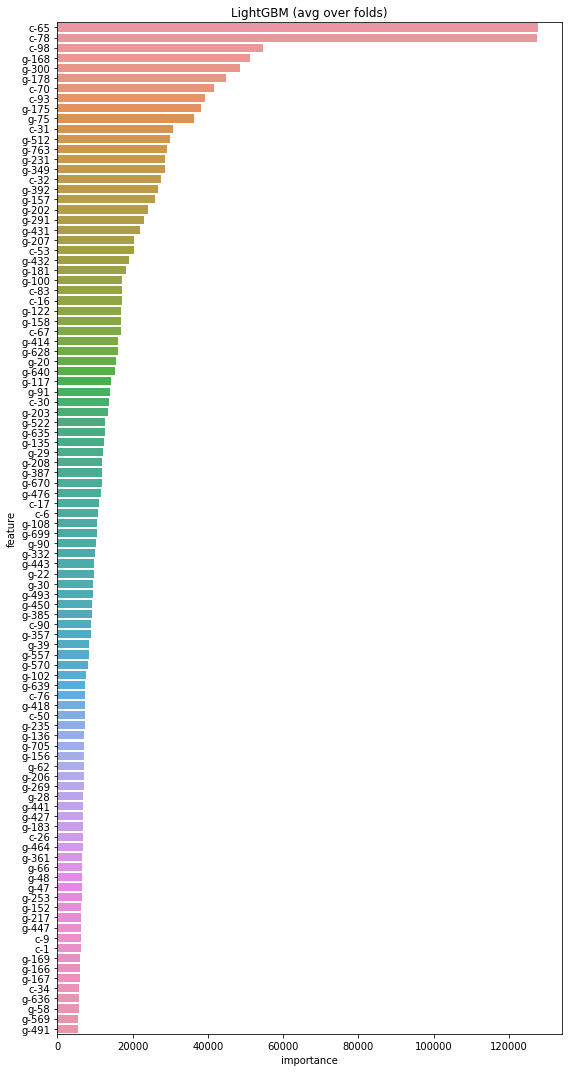

In [15]:
display_importances(importance_df)

# Platt Scaling
Train a Logistic Regression model to calibrate the results
- https://www.kaggle.com/gogo827jz/kernel-logistic-regression-one-for-206-targets

In [16]:
# predict_probaでだしたY_predをロジスティク回帰で確率に補正する

counts = np.empty((n_classes))

X_new = Y_pred.values
Y_cali = Y_pred.copy()

for tar in tqdm(range(Y.shape[1])):
    
    targets = Y.values[:, tar]
    X_targets = X_new[:, tar]
    counts[tar] = targets.sum()

    if targets.sum() >= n_splits:
        
        Y_cali[Y.columns[tar]] = np.zeros((Y_cali.shape[0], ))

        skf = StratifiedKFold(n_splits=n_splits, random_state=0, shuffle=True)

        for n, (tr, te) in enumerate(skf.split(targets, targets)):
            x_tr, x_val = X_targets[tr].reshape(-1, 1), X_targets[te].reshape(-1, 1)
            y_tr, y_val = targets[tr], targets[te]

            model = LogisticRegression(penalty="none", max_iter=1000)
            model.fit(x_tr, y_tr)
            Y_cali[Y.columns[tar]].iloc[te] += model.predict_proba(x_val)[:, 1]
            
            joblib.dump(model, f"calibrate_model_target_{Y.columns[tar]}.jlb", compress=True)

with open("counts_calibrate.pkl", "wb") as f:
    pickle.dump(counts, f)

with open("Y_pred_calibrate.pkl", "wb") as f:
    pickle.dump(Y_cali[columns], f)
    

100%|████████████████████████████████████████████████████████████████████████████████| 206/206 [00:30<00:00,  6.71it/s]


In [17]:
score(Y[columns], Y_cali[columns])

0.016605284585933078

# pkl check

In [18]:
path = r"counts.pkl"
with open(path, 'rb') as f:
    counts = pickle.load(f)
counts

array([10., 16., 16., ..., 24., 24., 24.])

In [19]:
path = r"counts_calibrate.pkl"
with open(path, 'rb') as f:
    counts = pickle.load(f)
counts

array([ 17.,  18.,  24., 190., 301.,  73.,  54.,  96.,  12., 270., 360.,
        66.,   7.,  42.,  12.,  12.,  48.,  89.,  80.,  36.,  37.,  73.,
         6.,  43.,  12.,  13.,  12.,  18.,  73.,  36.,  23.,  49.,  47.,
         6.,   1.,  12.,  97.,  19.,  96.,   6.,  60.,  80.,  36., 192.,
        89., 115.,   7.,  31.,  38.,  67.,  24.,  68.,  29.,   6., 281.,
        42.,  55.,  36.,  36.,  18.,  12., 102.,  18., 340.,  54.,  24.,
        42.,  48.,  54.,   6.,  36., 435., 104.,  36.,  25.,   6.,  48.,
       402., 121., 424., 336.,   6.,   1., 158.,  48.,  36.,  18.,  25.,
        50., 279.,  18.,  18.,  23., 106., 165.,  56., 266.,  13.,  74.,
       367.,  18.,  60.,  72., 106.,  59., 241.,  24.,  32.,  72., 283.,
        93.,  37.,  30.,  31.,  73.,  30.,  51.,  42.,  92., 273.,   6.,
         6.,  62.,  12.,  61.,   6.,  31.,  72.,  74.,  25.,  12.,  85.,
        18., 130.,  48.,  37., 832.,   6.,  26.,  12.,  26.,   7.,  18.,
        61.,  96.,  37.,  62.,  24.,  61., 297.,  1

In [20]:
path = r"Y_pred.pkl"
with open(path, 'rb') as f:
    Y_pred = pickle.load(f)
Y_pred

5-alpha_reductase_inhibitor  11-beta-hsd1_inhibitor  \
sig_id                                                              
id_000644bb2                     0.000303            6.256881e-04   
id_000779bfc                     0.000090            6.275407e-04   
id_000a6266a                     0.000835            9.598620e-04   
id_0015fd391                     0.000013            8.909441e-04   
id_001626bd3                     0.000003            8.269069e-04   
...                                   ...                     ...   
id_fffb1ceed                     0.001954            6.275407e-04   
id_fffb70c0c                     0.000001            2.523422e-08   
id_fffc1c3f4                     0.000000            0.000000e+00   
id_fffcb9e7c                     0.000068            6.275407e-04   
id_ffffdd77b                     0.000237            6.571837e-04   

              acat_inhibitor  acetylcholine_receptor_agonist  \
sig_id                                                         
id_000644bb2        0.001019                        0.009113   
id_000779bfc        0.000943                        0.015602   
id_000a6266a        0.001249                        0.005594   
id_0015fd391        0.001257                        0.003026   
id_001626bd3        0.001257                        0.014433   
...                      ...                             ...   
id_fffb1ceed        0.000943                        0.008363   
id_fffb70c0c        0.000914                        0.006345   
id_fffc1c3f4        0.000000                        0.000000   
id_fffcb9e7c        0.000943                        0.002227   
id_ffffdd77b        0.000883                        0.005382   

              acetylcholine_receptor_antagonist  \
sig_id                                            
id_000644bb2                           0.020552   
id_000779bfc                           0.017555   
id_000a6266a                           0.014091   
id_0015fd391                           0.005538   
id_001626bd3                           0.012057   
...                                         ...   
id_fffb1ceed                           0.020258   
id_fffb70c0c                           0.014299   
id_fffc1c3f4                           0.000000   
id_fffcb9e7c                           0.004733   
id_ffffdd77b                           0.004337   

              acetylcholinesterase_inhibitor  adenosine_receptor_agonist  \
sig_id                                                                     
id_000644bb2                        0.002872                    0.002489   
id_000779bfc                        0.002782                    0.002244   
id_000a6266a                        0.003188                    0.001419   
id_0015fd391                        0.003077                    0.001779   
id_001626bd3                        0.003376                    0.002112   
...                                      ...                         ...   
id_fffb1ceed                        0.003044                    0.002089   
id_fffb70c0c                        0.001609                    0.002385   
id_fffc1c3f4                        0.000000                    0.000000   
id_fffcb9e7c                        0.002831                    0.002552   
id_ffffdd77b                        0.002821                    0.002489   

              adenosine_receptor_antagonist  adenylyl_cyclase_activator  \
sig_id                                                                    
id_000644bb2                       0.003683                8.547011e-09   
id_000779bfc                       0.004180                9.737811e-05   
id_000a6266a                       0.004276                7.188949e-09   
id_0015fd391                       0.003928                4.668280e-05   
id_001626bd3                       0.003875                1.135250e-04   
...                                     ...                         ...   
id_fffb1ceed                  

In [21]:
path = r"Y_pred_calibrate.pkl"
with open(path, 'rb') as f:
    Y_pred = pickle.load(f)
Y_pred

5-alpha_reductase_inhibitor  11-beta-hsd1_inhibitor  \
sig_id                                                              
id_000644bb2                     0.000663                0.000758   
id_000779bfc                     0.000651                0.000787   
id_000a6266a                     0.000691                0.001158   
id_0015fd391                     0.000648                0.001061   
id_001626bd3                     0.000698                0.001038   
...                                   ...                     ...   
id_fffb1ceed                     0.000752                0.000763   
id_fffb70c0c                     0.000706                0.000388   
id_fffc1c3f4                     0.000650                0.000381   
id_fffcb9e7c                     0.000654                0.000763   
id_ffffdd77b                     0.000670                0.000787   

              acat_inhibitor  acetylcholine_receptor_agonist  \
sig_id                                                         
id_000644bb2        0.000997                        0.009172   
id_000779bfc        0.000982                        0.021577   
id_000a6266a        0.001195                        0.005732   
id_0015fd391        0.001173                        0.004299   
id_001626bd3        0.001202                        0.017448   
...                      ...                             ...   
id_fffb1ceed        0.000987                        0.008260   
id_fffb70c0c        0.001050                        0.006135   
id_fffc1c3f4        0.000565                        0.002529   
id_fffcb9e7c        0.000987                        0.003468   
id_ffffdd77b        0.000954                        0.005829   

              acetylcholine_receptor_antagonist  \
sig_id                                            
id_000644bb2                           0.025296   
id_000779bfc                           0.018842   
id_000a6266a                           0.013249   
id_0015fd391                           0.005439   
id_001626bd3                           0.011047   
...                                         ...   
id_fffb1ceed                           0.024618   
id_fffb70c0c                           0.013518   
id_fffc1c3f4                           0.003165   
id_fffcb9e7c                           0.005127   
id_ffffdd77b                           0.005313   

              acetylcholinesterase_inhibitor  adenosine_receptor_agonist  \
sig_id                                                                     
id_000644bb2                        0.003060                    0.002565   
id_000779bfc                        0.002987                    0.002284   
id_000a6266a                        0.003144                    0.001392   
id_0015fd391                        0.003114                    0.001745   
id_001626bd3                        0.003148                    0.002137   
...                                      ...                         ...   
id_fffb1ceed                        0.003065                    0.002194   
id_fffb70c0c                        0.002714                    0.002555   
id_fffc1c3f4                        0.002525                    0.001003   
id_fffcb9e7c                        0.003024                    0.002610   
id_ffffdd77b                        0.003047                    0.002565   

              adenosine_receptor_antagonist  adenylyl_cyclase_activator  \
sig_id                                                                    
id_000644bb2                       0.003794                    0.000499   
id_000779bfc                       0.004380                    0.000497   
id_000a6266a                       0.004441                    0.000489   
id_0015fd391                       0.004103                    0.000494   
id_001626bd3                       0.004048                    0.000501   
...                                     ...                         ...   
id_fffb1ceed                  

# predict test

In [22]:
import glob
import pathlib

test_features = pd.read_csv(
    "../input/lish-moa/test_features.csv", dtype=dtype, index_col=index_col
)
X_test = test_features.select_dtypes("number")


with open("./clipped_features.pkl", "rb") as f:
    clipped_features = pickle.load(f)
X_test = clipped_features.transform(X_test)
# アンサンブルのため統計値, nonscoredは入れない 
#X_c = compute_row_statistics(X_test.loc[:, c_columns], prefix=c_prefix)
#X_g = compute_row_statistics(X_test.loc[:, g_columns], prefix=g_prefix)
#X_test = pd.concat([X_test, X_c, X_g], axis=1)


# lgbで予測
Y_test_pred = np.zeros((X_test.shape[0], len(columns)))
Y_test_pred = pd.DataFrame(Y_test_pred, columns=columns, index=test_features.index)
for target in columns:
    model_paths = glob.glob(f"./model_seed_*_{target}.jlb")
    for model_path in model_paths:
        model = joblib.load(model_path)
        Y_test_pred[target] += model.predict(X_test) / len(model_paths)
print(Y_test_pred.shape)
display(Y_test_pred)


# lgbの予測値補正
model_paths = glob.glob(f"./calibrate_model_target_*.jlb")
for model_path in model_paths:
    target = str(pathlib.Path(model_path).stem).replace("calibrate_model_target_", "")

    if target in columns:
        # print(target)
        model = joblib.load(model_path)
        X_targets = Y_test_pred.loc[:, target].values.reshape(-1, 1)
        Y_test_pred.loc[:, target] = model.predict_proba(X_targets)[:, 1]

print(Y_test_pred.shape)
display(Y_test_pred)

FileNotFoundError: [Errno 2] No such file or directory: '../input/lish-moa/test_features.csv'